In [1]:
import matplotlib.pyplot as plt
from matplotlib import image
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
import cv2
import os
from BfTableGenerator import TDmapLoader
from tqdm import tqdm
from Utils import *
from open3d.web_visualizer import draw
from joblib import Parallel, delayed
from VisulizerTools import *
from DDBSCAN import Raster_DBSCAN
import time
plt.rcParams["font.family"] = "Times New Roman"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [34]:
aggregated_map = []
Inten_maps = []
pcap_path = r'D:\LiDAR_Data\MidTown\California\2021-12-9-9-30-0.pcap'
end_frame = 18000
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,Int_map = Frame
    aggregated_map.append(Td_map)
    Inten_maps.append(Int_map)
aggregated_map = np.array(aggregated_map)
Inten_maps = np.array(Inten_maps)

 99%|███████████████████████████████████████████████████████████████████████████▎| 17848/18000 [11:04<00:05, 26.86it/s]


In [6]:
test_points = pd.read_excel(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Data\TestPoint.xlsx')

In [2]:
def calc_d(d):
    temp = 3*10**(-5) * d**2 + 6.3*10**(-4) * d + 3.5*10**(-3)
    return 3*temp 

In [3]:
def get_thred(temp,N = 10,d_thred = 0.1,bck_n = 3):
    temp = temp.copy()
    total_sample = len(temp)
    bck_ds = []
    bck_portions = []
    repeat = 0
    while repeat < N:
        if len(temp) == 0:
            break
        sample = np.random.choice(temp,replace=False)
        d = calc_d(sample)
        ind = np.abs(temp - sample) < d
        portion = ind.sum()/total_sample
        if portion > d_thred:
            bck_portions.append(portion)
            bck_ds.append(sample)
            temp = temp[~ind]
        repeat += 1
        
    bck_ds = np.array(bck_ds)
    bck_portions = np.array(bck_portions)
    arg_ind = np.argsort(bck_portions)[::-1]
    bck_ds_ = bck_ds[arg_ind[:bck_n]]
    
    if len(bck_ds_) <= bck_n:
        bck_ds_ = np.concatenate([bck_ds_,-1 * np.ones(bck_n - len(bck_ds_))])
    return bck_ds_

def gen_bckmap(aggregated_maps, N, d_thred, bck_n):
    thred_map = np.zeros((3,32,1800))
    for i in tqdm(range(thred_map.shape[1])):
        for j in range(thred_map.shape[2]):
            thred_map[:,i,j] = get_thred(aggregated_maps[:,i,j],N = N,d_thred = d_thred,bck_n = bck_n)
    return thred_map

In [10]:
thred_map = gen_bckmap(aggregated_map, N = 10,d_thred = 0.08,bck_n = 3 )

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:49<00:00,  1.55s/it]


In [9]:
np.save(r'D:\LiDAR_Data\MidTown\California\Fri\thred_map_11.npy',thred_map)

In [19]:
Td_map = aggregated_map[12365]
Foreground_map = ~(np.abs(Td_map - thred_map) <= 1.5).any(axis = 0)
pcd = get_pcd_colored(Td_map,Foreground_map)
draw(pcd,height=1000,width=1000)# Labeling_map = self.db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)

WebVisualizer(window_uid='window_10')

In [14]:
for i in range(thred_map.shape[1]):
    for j in range(thred_map.shape[2]):
        if (thred_map[:,i,j] != -1).sum() > 1:
            print(i,j)

0 0
0 1
0 2
0 4
0 5
0 6
0 7
0 10
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 33
0 34
0 35
0 36
0 37
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 59
0 60
0 61
0 62
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 89
0 90
0 91
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 130
0 145
0 151
0 161
0 191
0 224
0 225
0 226
0 227
0 228
0 229
0 230
0 231
0 232
0 233
0 234
0 235
0 236
0 237
0 238
0 239
0 240
0 241
0 242
0 243
0 244
0 245
0 247
0 273
0 294
0 301
0 311
0 312
0 330
0 331
0 332
0 333
0 342
0 343
0 357
0 358
0 359
0 360
0 370
0 371
0 372
0 373
0 374
0 375
0 376
0 377
0 378
0 379
0 380
0 381
0 382
0 383
0 384
0 385
0 386
0 387
0 388
0 389
0 390
0 391
0 392
0 393
0 394
0 395
0 397
0 546
0 547
0 548
0 549
0 550
0 551
0 553
0 555
0 556
0 557
0 559
0 560
0 563
0 564
0 565
0 567
0 568
0 569
0 570
0 571
0 573
0 576
0 577
0 579
0 580
0 581
0 582
0 583
0 585
0 586
0 590
0 595
0 596
0 602
0 612
0 617
0 621
0 625
0 626
0 628

2 844
2 845
2 846
2 847
2 849
2 853
2 857
2 859
2 863
2 868
2 869
2 870
2 871
2 872
2 873
2 874
2 875
2 876
2 878
2 879
2 889
2 890
2 891
2 892
2 898
2 899
2 900
2 901
2 902
2 903
2 905
2 906
2 907
2 908
2 910
2 911
2 912
2 913
2 914
2 915
2 916
2 917
2 918
2 923
2 927
2 928
2 929
2 940
2 941
2 943
2 951
2 965
2 970
2 971
2 973
2 975
2 977
2 978
2 979
2 989
2 992
2 993
2 994
2 996
2 999
2 1001
2 1002
2 1003
2 1004
2 1006
2 1007
2 1008
2 1016
2 1017
2 1021
2 1022
2 1024
2 1027
2 1028
2 1030
2 1034
2 1035
2 1038
2 1054
2 1055
2 1056
2 1069
2 1081
2 1082
2 1102
2 1103
2 1104
2 1105
2 1170
2 1178
2 1179
2 1217
2 1218
2 1225
2 1226
2 1227
2 1236
2 1237
2 1238
2 1240
2 1242
2 1245
2 1246
2 1251
2 1252
2 1261
2 1263
2 1268
2 1271
2 1272
2 1274
2 1275
2 1276
2 1277
2 1278
2 1283
2 1289
2 1301
2 1304
2 1311
2 1321
2 1322
2 1326
2 1330
2 1335
2 1341
2 1345
2 1352
2 1354
2 1355
2 1356
2 1359
2 1361
2 1364
2 1376
2 1389
2 1390
2 1391
2 1393
2 1394
2 1403
2 1412
2 1414
2 1416
2 1422
2 1450
2 1452
2

5 286
5 288
5 291
5 292
5 297
5 298
5 299
5 311
5 312
5 313
5 314
5 315
5 321
5 322
5 323
5 324
5 325
5 326
5 327
5 328
5 329
5 330
5 331
5 332
5 333
5 334
5 335
5 336
5 341
5 342
5 343
5 345
5 346
5 348
5 349
5 350
5 351
5 352
5 353
5 354
5 355
5 356
5 357
5 358
5 360
5 361
5 362
5 363
5 364
5 367
5 368
5 371
5 372
5 373
5 375
5 376
5 377
5 378
5 379
5 384
5 385
5 386
5 388
5 389
5 390
5 391
5 546
5 548
5 549
5 550
5 551
5 552
5 553
5 554
5 556
5 557
5 561
5 570
5 575
5 576
5 577
5 581
5 582
5 583
5 584
5 585
5 587
5 588
5 589
5 591
5 593
5 594
5 595
5 596
5 597
5 606
5 609
5 619
5 620
5 621
5 623
5 626
5 632
5 638
5 639
5 641
5 642
5 645
5 655
5 665
5 666
5 667
5 671
5 706
5 707
5 715
5 718
5 719
5 748
5 797
5 799
5 800
5 805
5 807
5 808
5 809
5 810
5 811
5 812
5 828
5 829
5 830
5 843
5 844
5 845
5 846
5 847
5 852
5 855
5 856
5 857
5 886
5 887
5 890
5 892
5 893
5 921
5 922
5 923
5 925
5 930
5 942
5 943
5 944
5 945
5 946
5 947
5 948
5 949
5 950
5 951
5 952
5 953
5 955
5 956
5 957
5 95

7 375
7 376
7 377
7 378
7 379
7 380
7 381
7 382
7 383
7 384
7 385
7 386
7 387
7 395
7 396
7 398
7 399
7 401
7 402
7 551
7 552
7 553
7 554
7 555
7 557
7 561
7 563
7 570
7 571
7 572
7 574
7 575
7 576
7 577
7 578
7 579
7 581
7 582
7 583
7 584
7 585
7 590
7 591
7 592
7 593
7 595
7 598
7 599
7 600
7 606
7 607
7 614
7 632
7 633
7 634
7 635
7 636
7 638
7 640
7 680
7 688
7 689
7 692
7 694
7 695
7 697
7 698
7 701
7 702
7 703
7 704
7 721
7 752
7 798
7 799
7 800
7 801
7 803
7 805
7 806
7 807
7 808
7 817
7 818
7 819
7 820
7 821
7 822
7 823
7 825
7 826
7 827
7 828
7 829
7 830
7 831
7 832
7 833
7 834
7 835
7 836
7 837
7 838
7 839
7 841
7 843
7 845
7 846
7 847
7 848
7 849
7 850
7 851
7 852
7 853
7 854
7 855
7 856
7 857
7 858
7 859
7 860
7 861
7 862
7 863
7 864
7 865
7 869
7 870
7 871
7 872
7 873
7 874
7 875
7 879
7 882
7 883
7 884
7 886
7 888
7 890
7 896
7 899
7 901
7 902
7 905
7 915
7 918
7 920
7 921
7 926
7 929
7 935
7 936
7 937
7 938
7 939
7 940
7 941
7 942
7 943
7 944
7 945
7 946
7 947
7 948
7 94

9 307
9 308
9 309
9 310
9 313
9 314
9 319
9 320
9 322
9 323
9 325
9 326
9 327
9 329
9 338
9 341
9 342
9 343
9 345
9 346
9 347
9 348
9 349
9 351
9 352
9 353
9 354
9 355
9 356
9 357
9 358
9 360
9 361
9 363
9 365
9 366
9 367
9 368
9 369
9 374
9 375
9 377
9 378
9 379
9 380
9 381
9 545
9 547
9 549
9 550
9 552
9 553
9 555
9 556
9 563
9 565
9 571
9 573
9 574
9 575
9 576
9 579
9 580
9 581
9 582
9 595
9 596
9 599
9 600
9 603
9 608
9 610
9 621
9 622
9 623
9 629
9 632
9 633
9 641
9 642
9 643
9 644
9 660
9 661
9 674
9 675
9 676
9 683
9 798
9 800
9 801
9 802
9 804
9 805
9 806
9 807
9 809
9 810
9 814
9 817
9 818
9 819
9 820
9 823
9 824
9 829
9 833
9 841
9 843
9 845
9 846
9 848
9 851
9 853
9 854
9 855
9 857
9 858
9 859
9 861
9 865
9 866
9 868
9 869
9 872
9 873
9 884
9 886
9 887
9 891
9 892
9 893
9 895
9 897
9 898
9 902
9 909
9 910
9 917
9 918
9 920
9 921
9 923
9 927
9 928
9 937
9 938
9 939
9 944
9 945
9 966
9 968
9 996
9 997
9 1000
9 1001
9 1002
9 1003
9 1005
9 1007
9 1008
9 1012
9 1014
9 1017
9 1019

11 203
11 204
11 205
11 206
11 207
11 208
11 209
11 210
11 211
11 212
11 213
11 214
11 215
11 216
11 217
11 218
11 219
11 220
11 221
11 222
11 224
11 225
11 226
11 227
11 228
11 229
11 230
11 231
11 232
11 233
11 234
11 235
11 236
11 237
11 238
11 239
11 240
11 241
11 242
11 243
11 244
11 246
11 248
11 249
11 250
11 251
11 252
11 253
11 254
11 255
11 256
11 257
11 258
11 259
11 260
11 261
11 262
11 263
11 264
11 265
11 266
11 270
11 271
11 272
11 273
11 274
11 275
11 278
11 279
11 280
11 281
11 282
11 283
11 284
11 285
11 286
11 287
11 288
11 289
11 293
11 294
11 296
11 297
11 298
11 299
11 300
11 301
11 303
11 304
11 306
11 313
11 314
11 316
11 318
11 326
11 327
11 328
11 330
11 331
11 332
11 335
11 336
11 337
11 338
11 339
11 340
11 341
11 342
11 344
11 345
11 346
11 347
11 348
11 349
11 350
11 351
11 353
11 354
11 355
11 356
11 357
11 358
11 361
11 364
11 365
11 366
11 367
11 368
11 369
11 373
11 374
11 377
11 378
11 379
11 380
11 386
11 388
11 389
11 390
11 391
11 392
11 393
11 394

13 183
13 184
13 185
13 186
13 187
13 189
13 191
13 192
13 193
13 194
13 197
13 198
13 199
13 200
13 202
13 203
13 204
13 205
13 206
13 207
13 208
13 209
13 213
13 214
13 215
13 216
13 217
13 218
13 219
13 220
13 221
13 222
13 223
13 224
13 225
13 226
13 227
13 228
13 229
13 230
13 231
13 232
13 233
13 234
13 235
13 237
13 238
13 239
13 240
13 241
13 242
13 243
13 244
13 245
13 247
13 248
13 249
13 250
13 251
13 252
13 253
13 254
13 256
13 257
13 259
13 260
13 262
13 263
13 264
13 265
13 266
13 268
13 273
13 274
13 275
13 277
13 278
13 280
13 281
13 282
13 283
13 289
13 290
13 291
13 293
13 294
13 295
13 296
13 297
13 298
13 299
13 300
13 301
13 302
13 303
13 304
13 310
13 311
13 312
13 313
13 315
13 316
13 322
13 329
13 330
13 331
13 333
13 334
13 335
13 337
13 338
13 340
13 341
13 342
13 343
13 344
13 345
13 346
13 348
13 349
13 351
13 353
13 354
13 355
13 356
13 358
13 359
13 360
13 361
13 362
13 363
13 364
13 365
13 366
13 368
13 369
13 370
13 372
13 374
13 375
13 376
13 378
13 379

15 577
15 578
15 579
15 582
15 583
15 585
15 606
15 607
15 609
15 611
15 612
15 613
15 616
15 626
15 630
15 631
15 632
15 633
15 636
15 643
15 645
15 646
15 649
15 650
15 653
15 668
15 669
15 671
15 675
15 681
15 682
15 686
15 693
15 694
15 720
15 721
15 744
15 746
15 747
15 759
15 796
15 798
15 800
15 801
15 803
15 804
15 806
15 828
15 829
15 835
15 839
15 843
15 845
15 846
15 847
15 865
15 868
15 869
15 883
15 884
15 885
15 886
15 890
15 891
15 892
15 893
15 895
15 896
15 897
15 900
15 901
15 903
15 904
15 905
15 906
15 908
15 912
15 913
15 914
15 917
15 920
15 921
15 922
15 923
15 946
15 947
15 948
15 952
15 953
15 954
15 958
15 959
15 964
15 965
15 966
15 967
15 968
15 970
15 971
15 977
15 978
15 985
15 986
15 994
15 995
15 996
15 997
15 998
15 999
15 1000
15 1001
15 1002
15 1003
15 1005
15 1006
15 1007
15 1008
15 1009
15 1010
15 1011
15 1012
15 1013
15 1014
15 1021
15 1036
15 1042
15 1043
15 1046
15 1047
15 1049
15 1050
15 1053
15 1062
15 1076
15 1077
15 1078
15 1079
15 1080
15 10

17 1480
17 1481
17 1483
17 1484
17 1485
17 1486
17 1487
17 1488
17 1492
17 1498
17 1504
17 1510
17 1511
17 1514
17 1517
17 1518
17 1519
17 1520
17 1521
17 1533
17 1534
17 1539
17 1540
17 1545
17 1560
17 1561
17 1562
17 1566
17 1574
17 1576
17 1579
17 1595
17 1597
17 1607
17 1610
17 1612
17 1613
17 1614
17 1615
17 1616
17 1617
17 1619
17 1627
17 1628
17 1629
17 1634
17 1635
17 1636
17 1639
17 1643
17 1658
17 1659
17 1660
17 1661
17 1662
17 1664
17 1665
17 1666
17 1667
17 1669
17 1670
17 1671
17 1673
17 1674
17 1675
17 1679
17 1681
17 1682
17 1684
17 1685
17 1686
17 1689
17 1690
17 1691
17 1693
17 1694
17 1695
17 1696
17 1697
17 1698
17 1699
17 1700
17 1702
17 1703
17 1704
17 1705
17 1706
17 1707
17 1708
17 1709
17 1710
17 1711
17 1712
17 1713
17 1714
17 1715
17 1716
17 1717
17 1718
17 1720
17 1721
17 1722
17 1723
17 1725
17 1727
17 1728
17 1729
17 1730
17 1731
17 1732
17 1733
17 1734
17 1737
17 1738
17 1740
17 1741
17 1742
17 1743
17 1744
17 1745
17 1746
17 1747
17 1748
17 1750
17 1751


20 51
20 52
20 53
20 54
20 55
20 56
20 57
20 58
20 60
20 61
20 62
20 63
20 64
20 65
20 67
20 68
20 70
20 72
20 73
20 74
20 75
20 76
20 79
20 80
20 81
20 82
20 83
20 84
20 88
20 89
20 90
20 91
20 92
20 93
20 94
20 95
20 96
20 97
20 98
20 99
20 100
20 101
20 103
20 104
20 105
20 106
20 107
20 108
20 109
20 110
20 111
20 112
20 113
20 114
20 115
20 116
20 118
20 119
20 120
20 122
20 123
20 124
20 125
20 126
20 127
20 135
20 136
20 137
20 138
20 139
20 141
20 142
20 143
20 144
20 146
20 147
20 148
20 149
20 150
20 154
20 155
20 157
20 162
20 163
20 164
20 166
20 167
20 168
20 169
20 170
20 171
20 172
20 173
20 176
20 177
20 178
20 179
20 180
20 181
20 182
20 186
20 187
20 188
20 189
20 190
20 191
20 192
20 193
20 194
20 195
20 196
20 197
20 198
20 199
20 200
20 201
20 202
20 203
20 204
20 205
20 206
20 207
20 208
20 209
20 210
20 212
20 213
20 214
20 215
20 216
20 217
20 218
20 219
20 221
20 222
20 223
20 224
20 225
20 226
20 227
20 228
20 229
20 230
20 231
20 236
20 237
20 238
20 242
20 2

22 1364
22 1365
22 1366
22 1367
22 1368
22 1369
22 1370
22 1374
22 1378
22 1384
22 1387
22 1390
22 1391
22 1393
22 1394
22 1397
22 1400
22 1402
22 1407
22 1408
22 1413
22 1414
22 1415
22 1419
22 1425
22 1427
22 1434
22 1436
22 1437
22 1438
22 1440
22 1448
22 1455
22 1458
22 1459
22 1463
22 1464
22 1465
22 1466
22 1474
22 1475
22 1477
22 1478
22 1479
22 1480
22 1483
22 1487
22 1488
22 1489
22 1493
22 1497
22 1499
22 1502
22 1504
22 1510
22 1511
22 1512
22 1513
22 1514
22 1518
22 1519
22 1520
22 1521
22 1525
22 1529
22 1536
22 1537
22 1546
22 1547
22 1555
22 1560
22 1561
22 1562
22 1563
22 1572
22 1573
22 1574
22 1576
22 1578
22 1580
22 1581
22 1582
22 1583
22 1586
22 1587
22 1588
22 1594
22 1596
22 1597
22 1598
22 1600
22 1605
22 1606
22 1607
22 1612
22 1613
22 1614
22 1615
22 1616
22 1638
22 1653
22 1654
22 1655
22 1656
22 1657
22 1658
22 1659
22 1660
22 1661
22 1662
22 1663
22 1666
22 1667
22 1668
22 1669
22 1670
22 1672
22 1675
22 1676
22 1678
22 1679
22 1680
22 1681
22 1682
22 1683


24 1609
24 1611
24 1614
24 1622
24 1623
24 1627
24 1630
24 1631
24 1635
24 1636
24 1638
24 1639
24 1645
24 1646
24 1648
24 1650
24 1652
24 1661
24 1662
24 1663
24 1664
24 1665
24 1667
24 1668
24 1669
24 1670
24 1671
24 1672
24 1673
24 1674
24 1675
24 1676
24 1678
24 1679
24 1680
24 1681
24 1682
24 1683
24 1684
24 1685
24 1686
24 1689
24 1692
24 1693
24 1694
24 1695
24 1696
24 1697
24 1698
24 1700
24 1701
24 1702
24 1703
24 1704
24 1705
24 1707
24 1708
24 1709
24 1710
24 1711
24 1712
24 1715
24 1716
24 1717
24 1718
24 1719
24 1720
24 1721
24 1722
24 1723
24 1728
24 1729
24 1730
24 1731
24 1732
24 1733
24 1734
24 1735
24 1736
24 1737
24 1739
24 1740
24 1741
24 1742
24 1743
24 1744
24 1745
24 1746
24 1748
24 1749
24 1750
24 1753
24 1754
24 1755
24 1756
24 1757
24 1759
24 1760
24 1761
24 1764
24 1766
24 1767
24 1768
24 1769
24 1770
24 1771
24 1773
24 1774
24 1775
24 1776
24 1777
24 1778
24 1780
24 1781
24 1793
24 1794
24 1795
24 1796
24 1798
24 1799
25 0
25 2
25 4
25 5
25 9
25 10
25 11
25 

27 251
27 252
27 253
27 255
27 257
27 258
27 259
27 260
27 262
27 264
27 265
27 266
27 267
27 268
27 269
27 270
27 271
27 272
27 273
27 274
27 277
27 278
27 279
27 280
27 282
27 283
27 284
27 288
27 293
27 294
27 295
27 296
27 297
27 298
27 299
27 301
27 302
27 304
27 305
27 306
27 307
27 308
27 309
27 310
27 311
27 312
27 313
27 314
27 315
27 317
27 319
27 320
27 321
27 327
27 329
27 332
27 333
27 334
27 335
27 336
27 337
27 338
27 339
27 340
27 341
27 344
27 345
27 346
27 347
27 348
27 349
27 350
27 351
27 352
27 353
27 354
27 355
27 356
27 357
27 358
27 359
27 360
27 361
27 363
27 364
27 365
27 366
27 367
27 368
27 369
27 370
27 371
27 373
27 374
27 375
27 376
27 379
27 380
27 381
27 384
27 386
27 387
27 388
27 389
27 393
27 394
27 395
27 546
27 547
27 548
27 549
27 550
27 551
27 553
27 561
27 562
27 565
27 567
27 568
27 569
27 570
27 573
27 580
27 582
27 629
27 654
27 655
27 656
27 659
27 660
27 661
27 663
27 666
27 691
27 694
27 718
27 721
27 722
27 723
27 733
27 797
27 804
27 824

30 70
30 74
30 75
30 76
30 77
30 78
30 79
30 80
30 81
30 82
30 83
30 84
30 85
30 86
30 87
30 88
30 89
30 90
30 91
30 92
30 93
30 94
30 95
30 97
30 116
30 117
30 119
30 120
30 122
30 127
30 129
30 130
30 131
30 132
30 133
30 135
30 136
30 137
30 138
30 139
30 140
30 141
30 142
30 143
30 144
30 145
30 146
30 147
30 148
30 149
30 150
30 151
30 152
30 162
30 164
30 165
30 166
30 167
30 168
30 169
30 170
30 171
30 172
30 174
30 175
30 176
30 177
30 178
30 179
30 180
30 181
30 182
30 184
30 188
30 189
30 190
30 191
30 192
30 193
30 194
30 195
30 196
30 197
30 198
30 199
30 200
30 201
30 202
30 203
30 204
30 205
30 206
30 207
30 208
30 209
30 210
30 211
30 212
30 213
30 214
30 215
30 216
30 217
30 218
30 221
30 223
30 224
30 225
30 226
30 227
30 228
30 229
30 230
30 231
30 232
30 233
30 234
30 235
30 236
30 237
30 238
30 239
30 240
30 241
30 242
30 243
30 244
30 246
30 247
30 248
30 249
30 250
30 251
30 252
30 253
30 254
30 255
30 256
30 257
30 258
30 259
30 260
30 261
30 262
30 263
30 264
30

In [13]:
thred_map[:,0,3]

array([ 5.784, -1.   , -1.   ])

46.992000000000004
1557


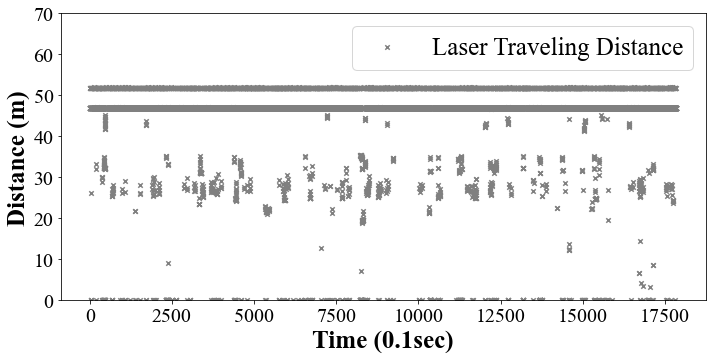

In [26]:
laser_id = 20
azimuth_channel = 1557
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
# thred = thred_map[:,laser_id,azimuth_channel]
plt.legend(fontsize = 25)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.ylim(0,70)

# plt.xlim(1400,1500)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\parameterdefinition.tif', dpi = 600)
plt.show()

46.992000000000004
1557


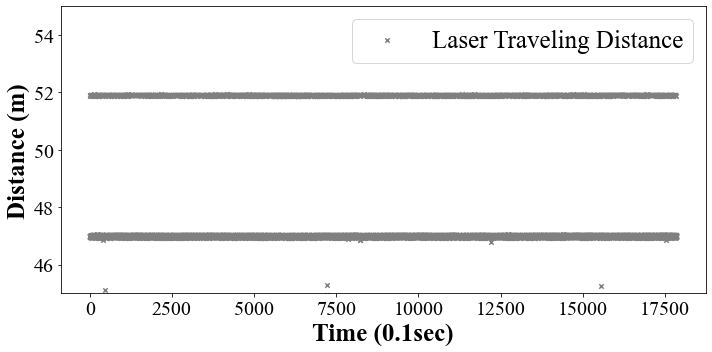

In [28]:
laser_id = 20
azimuth_channel = 1557
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
# thred = thred_map[:,laser_id,azimuth_channel]
plt.legend(fontsize = 25)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.ylim(45,55)

# plt.xlim(1400,1500)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\parameterdefinition_sub.tif', dpi = 600)
plt.show()

In [53]:
Td_map = aggregated_map[446]
Colored_map = -1*np.ones_like(Td_map)
Colored_map[3:4,1150:1200] = 0
Colored_map = Colored_map.astype(int)
pcd = get_pcd_colored(Td_map,Colored_map)
draw(pcd,height=1000,width=1000)


WebVisualizer(window_uid='window_45')

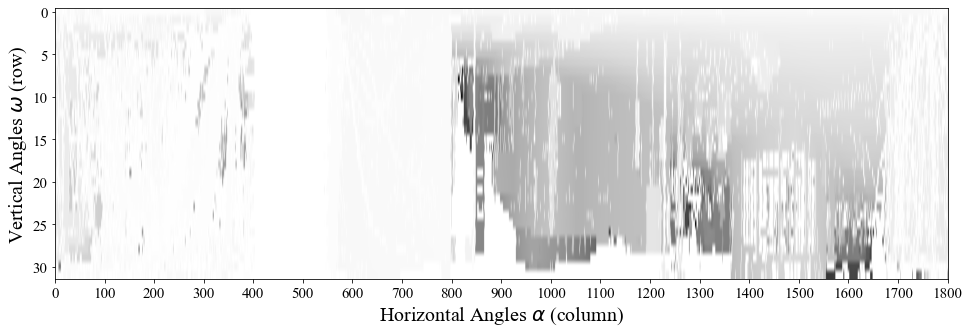

In [12]:
plt.figure(figsize=(16,5))
plt.imshow(aggregated_map[235], aspect='auto',cmap = 'binary')
plt.xlabel(r'Horizontal Angles $\mathit{\alpha}$ (column)',fontsize = 20)
plt.ylabel(r'Vertical Angles $\mathit{\omega} $ (row)',fontsize = 20)
plt.yticks(fontsize = 15)
plt.xticks(np.arange(0,1900,100),fontsize = 15)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\Picture4.tif',dpi = 600)
plt.show()

[0.]
148


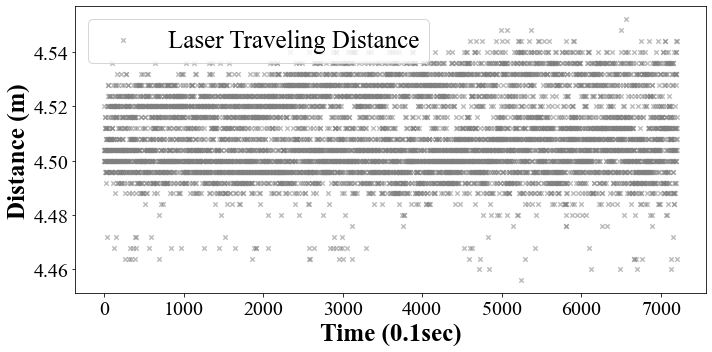

In [7]:
laser_id = theta_raw[28] == theta
azimuth_channel = int(np.around((2354/100)/0.2)) + 30
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
temp = temp[temp != 0]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray', alpha = 0.5)
plt.legend(fontsize = 25)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
# plt.ylim(32.8,33)
plt.tight_layout()
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\zoominband.png', dpi = 300)
plt.show()

[32.868]
1463


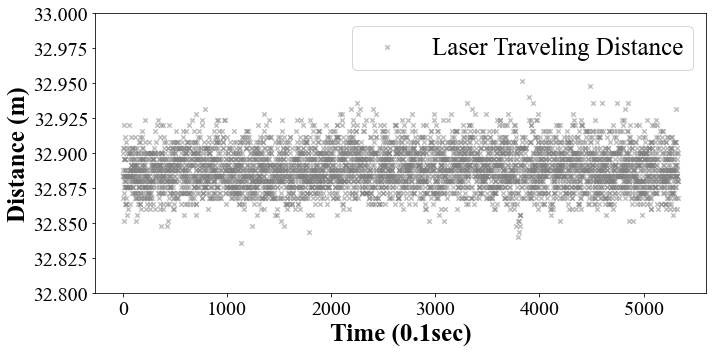

In [35]:
laser_id = theta_raw[28] == theta
azimuth_channel = int(np.around((28661/100)/0.2)) + 30
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
temp = temp[temp != 0]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray', alpha = 0.5)
plt.legend(fontsize = 25)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.ylim(32.8,33)
plt.tight_layout()
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\zoominband.png', dpi = 300)
plt.show()

[50.528]
166


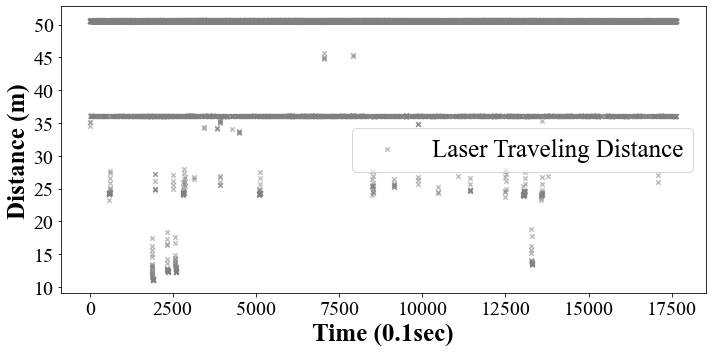

In [79]:
laser_id = theta_raw[2] == theta
azimuth_channel = int(np.around((2711/100)/0.2)) + 30
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
temp = temp[temp != 0]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray', alpha = 0.5)
plt.legend(fontsize = 25)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
# plt.ylim(32.8,33)
plt.tight_layout()
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\zoominband.png', dpi = 300)
plt.show()

[32.868]
1463


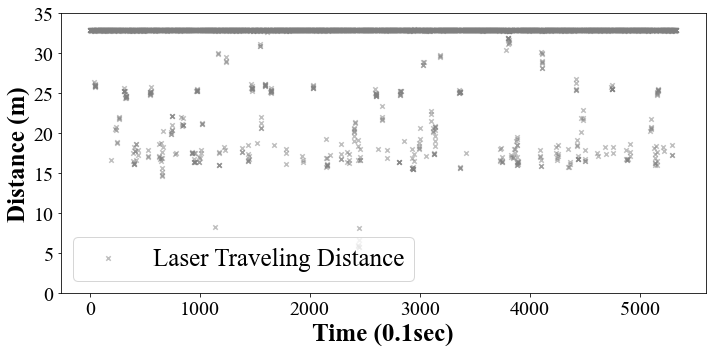

In [36]:
laser_id = theta_raw[28] == theta
azimuth_channel = int(np.around((28661/100)/0.2)) + 30
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
temp = temp[temp != 0]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray', alpha = 0.5)
plt.legend(fontsize = 25)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.ylim(0,35)
plt.tight_layout()
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\band.png', dpi = 300)
plt.show()

In [176]:
theta_raw = np.array([[-25,1.4],[-1,-4.2],[-1.667,1.4],[-15.639,-1.4],
                            [-11.31,1.4],[0,-1.4],[-0.667,4.2],[-8.843,-1.4],
                            [-7.254,1.4],[0.333,-4.2],[-0.333,1.4],[-6.148,-1.4],
                            [-5.333,4.2],[1.333,-1.4],[0.667,4.2],[-4,-1.4],
                            [-4.667,1.4],[1.667,-4.2],[1,1.4],[-3.667,-4.2],
                            [-3.333,4.2],[3.333,-1.4],[2.333,1.4],[-2.667,-1.4],
                            [-3,1.4],[7,-1.4],[4.667,1.4],[-2.333,-4.2],
                            [-2,4.2],[15,-1.4],[10.333,1.4],[-1.333,-1.4]
                            ])[:,0]

In [41]:
aggregated_map = np.array(aggregated_map)

22.884
1354


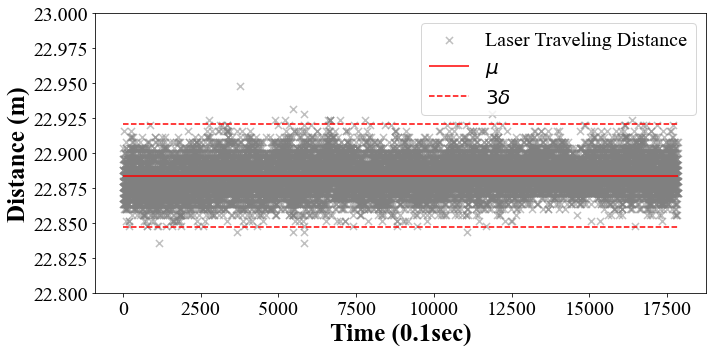

In [54]:
laser_id = 5
azimuth_channel = 1354
print(np.median(aggregated_map[:,laser_id,azimuth_channel]))
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 50, marker = 'x', label = "Laser Traveling Distance", c = 'gray', alpha = 0.5)
test = temp[(temp >22.8)&(temp < 23)]
plt.hlines(test.mean(),0,len(temp),color = 'r',label = '$\mu$')
plt.hlines(test.mean() + 3*test.std(),0,len(temp),color = 'r',label = '$3\delta$',linestyles = 'dashed')
plt.hlines(test.mean() - 3*test.std(),0,len(temp),color = 'r',linestyles = 'dashed')
plt.legend(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.ylim(22.8,23)
plt.tight_layout()
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\DsWidth.tif',dpi = 600)
plt.show()

44.788000000000004
1354


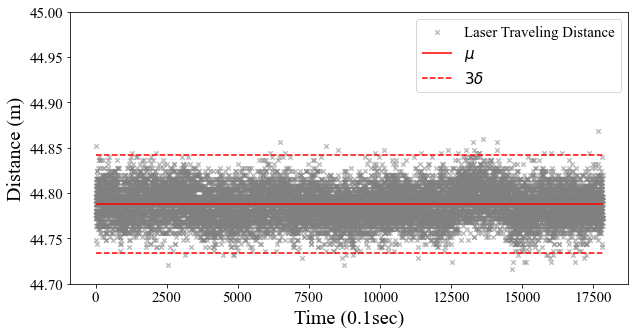

In [76]:
laser_id = 5
azimuth_channel = 1354
print(np.median(aggregated_map[:,laser_id,azimuth_channel]))
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray', alpha = 0.5)
test = temp[(temp >44.7)&(temp < 44.9)]
plt.hlines(test.mean(),0,len(temp),color = 'r',label = '$\mu$')
plt.hlines(test.mean() + 3*test.std(),0,len(temp),color = 'r',label = '$3\delta$',linestyles = 'dashed')
plt.hlines(test.mean() - 3*test.std(),0,len(temp),color = 'r',linestyles = 'dashed')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
plt.ylim(44.7,45)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\DsWidth.tif',dpi = 600)
plt.show()

56.048
1354


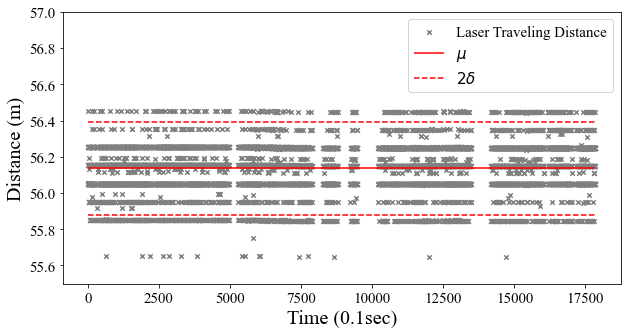

In [46]:
laser_id = 16
azimuth_channel = 1354
print(np.median(aggregated_map[:,laser_id,azimuth_channel]))
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
plt.hlines(test.mean(),0,len(temp),color = 'r',label = '$\mu$')
plt.hlines(test.mean() + 2*test.std(),0,len(temp),color = 'r',label = '$2\delta$',linestyles = 'dashed')
plt.hlines(test.mean() - 2*test.std(),0,len(temp),color = 'r',linestyles = 'dashed')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
plt.ylim(55.5,57)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\contantWidth.tif',dpi = 600)
plt.show()

In [27]:
test = temp[(temp >55.5)&(temp < 56.8)]


In [680]:
test = temp[(temp >192)&(temp < 194)]
med = np.median(test)
np.save(r'D:\LiDAR_Data\AmplitudeTest\Liberty\Snowy/{}.npy'.format(med),test)

In [34]:
Td_map = aggregated_map[482]
Colored_map = -1*np.ones_like(Td_map)
Colored_map[6:8,1750:1799] = 0
Colored_map = Colored_map.astype(int)
pcd = get_pcd_colored(Td_map,Colored_map)
draw(pcd,height=1000,width=1000)


WebVisualizer(window_uid='window_7')

18.624
1226


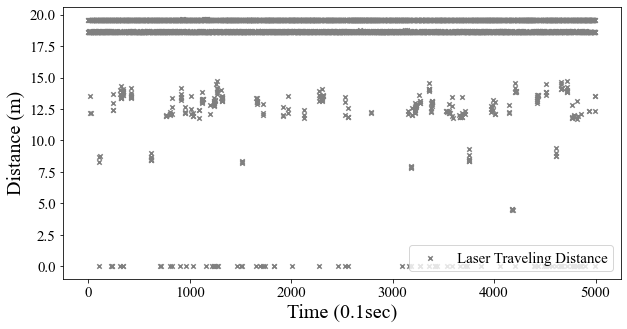

In [66]:
laser_id = 3
azimuth_channel = 1226
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
# for i in range(len(thred)):
#     plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.legend(fontsize = 15,loc = 'lower right')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
# plt.ylim(3,3.25)
# plt.xlim(1400,1500)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\MultiModal2.tif', dpi = 600)
plt.show()

18.624
1226


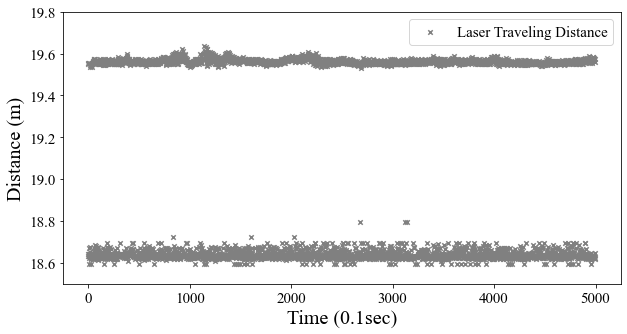

In [74]:
laser_id = 3
azimuth_channel = 1226
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
# for i in range(len(thred)):
#     plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
plt.ylim(18.5,19.8)
# plt.xlim(1400,1500)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\MultiModal3.tif', dpi = 600)
plt.show()

0.0
138


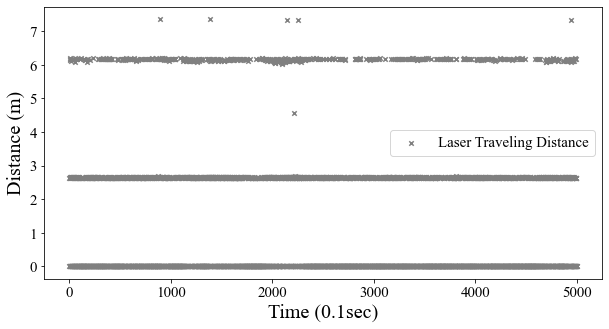

In [45]:
laser_id = 8
azimuth_channel = int((3376/100)/0.2) - 30
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
# for i in range(len(thred)):
#     plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
# plt.ylim(0,65)
# plt.xlim(1400,1500)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\MultiModal.tif', dpi = 600)
plt.show()

29.580000000000002
1345


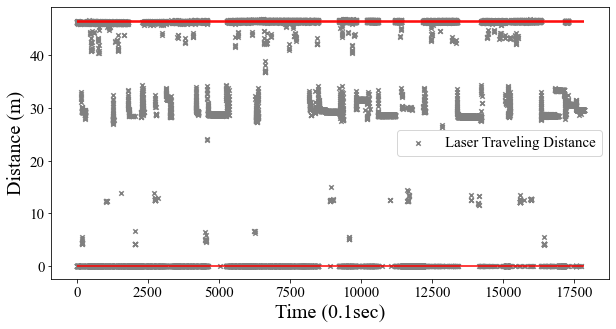

In [29]:
laser_id = 3
azimuth_channel = 1345
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
for i in range(len(thred)):
    plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
# plt.ylim(0,65)
# plt.xlim(1400,1500)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\MultiModal.tif', dpi = 600)
plt.show()

[16.412]
1743


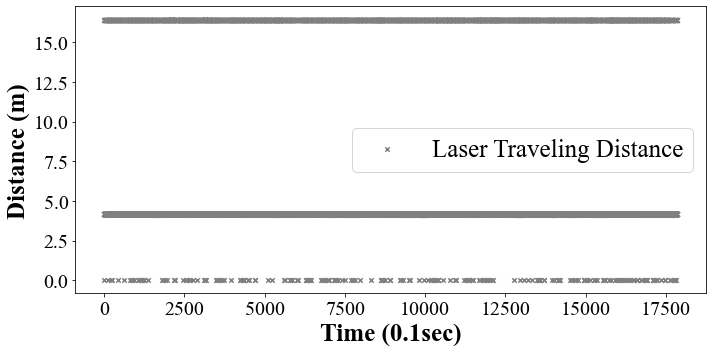

In [87]:
laser_id = theta_raw[23] == theta
azimuth_channel = int((35461/100)/0.2) - 30
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
# thred = thred_map[:,laser_id,azimuth_channel]
# for i in range(len(thred)):
#     plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.legend(fontsize = 25)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
# plt.ylim(0,14)
# plt.xlim(1400,1500)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\MultiModal2.tif', dpi = 300)
plt.show()

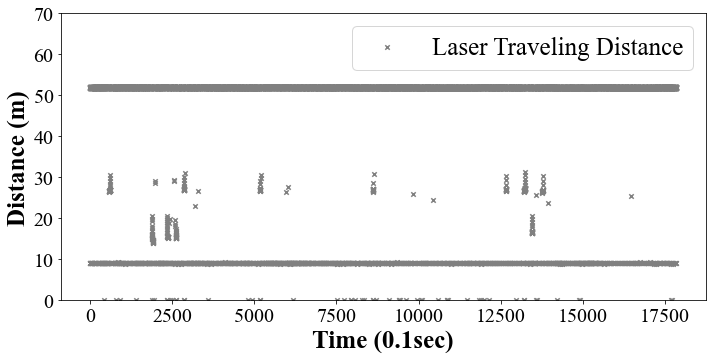

In [85]:
laser_id = theta_raw[5] == theta
azimuth_channel = int((3376/100)/0.2) - 30
# print(aggregated_map[-4,laser_id,azimuth_channel])
# print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
# thred = thred_map[:,laser_id,azimuth_channel]
# for i in range(len(thred)):
#     plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.legend(fontsize = 25)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.ylim(0,70)
# plt.xlim(1400,1500)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\MultiModal.tif', dpi = 300)
plt.show()

[51.9]
138


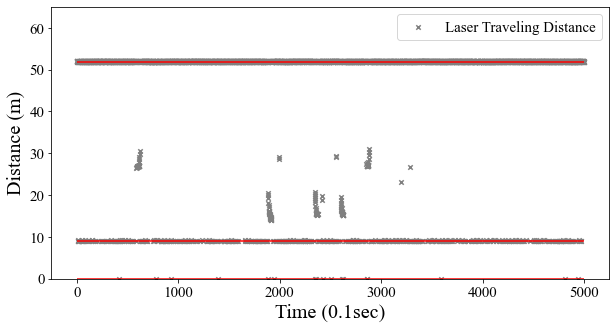

In [9]:
laser_id = theta_raw[5] == theta
azimuth_channel = int((3376/100)/0.2) - 30
print(aggregated_map[-4,laser_id,azimuth_channel])
print(azimuth_channel)
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
thred = thred_map[:,laser_id,azimuth_channel]
for i in range(len(thred)):
    plt.hlines(thred[i],0,aggregated_map.shape[0],color = 'r')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
plt.ylim(0,65)
# plt.xlim(1400,1500)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\MultiModal.tif', dpi = 600)
plt.show()

In [22]:
thred_map = gen_bckmap(aggregated_map, d = 0.5, thred_s = 0.3, N = 20, delta_thred = 0.001, step = 0.1)

In [14]:
np.save(r'D:\Test\bck.npy',thred_map)

In [13]:
Td_map = aggregated_map[482]
Colored_map = Td_map < thred_map
# Colored_map[:,700:900] = 1
pcd = get_pcd_colored(Td_map,Colored_map)
draw(pcd,height=1000,width=1000)


WebVisualizer(window_uid='window_3')

In [15]:
f_path = r'D:\LiDAR_Data\AmplitudeTest\Total'
path_amp = os.listdir(f_path)
dis_Total  = []
amps = []
for p in path_amp:
    test = np.load(os.path.join(f_path,p))
    dis_Total .append(eval(p[:-4]))
    amps.append(test)
stds_Total  = np.array([a.std() for a in amps])
lenths_Total = np.array([len(a) for a in amps])
dis_Total = np.array(dis_Total)
amps_2stds = []
for i,a in enumerate(amps):
    std = stds_Total[i]
    amps_2stds.append(a[(a > a.mean() - 3*std )&(a < a.mean() + 3*std)].std())
amps_2stds = np.array(amps_2stds) 

C:\Users\zhChe\.conda\envs\tracking\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\zhChe\.conda\envs\tracking\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\zhChe\.conda\envs\tracking\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
stds_Total = stds_Total[dis_Total < 100]
dis_Total = dis_Total[dis_Total < 100] 

In [17]:
from scipy.optimize import curve_fit
def func(x, a, b,c):
    return a * x**2 + b*x + c 
popt, pcov = curve_fit(func, dis_Total, stds_Total)
x = np.arange(0,180)
y = popt[0] * x**2 + popt[1] * x + popt[2]

In [18]:
residuals = stds_Total - func(dis_Total,*popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((stds_Total-np.mean(stds_Total))**2)
r_squared = 1 - (ss_res / ss_tot)



In [19]:
r_squared

0.7537589119419852

In [20]:
pcov

array([[ 5.62691025e-11, -4.45210567e-09,  5.57972756e-08],
       [-4.45210567e-09,  3.88224335e-07, -5.52197728e-06],
       [ 5.57972756e-08, -5.52197728e-06,  1.07268498e-04]])

In [21]:
popt

array([ 7.30383458e-05, -2.79213761e-03,  3.92669602e-02])

In [ ]:
plt.legend(fontsize = 25)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.ylabel('Distance (m)',fontsize = 25, fontweight = 'bold')
plt.xlabel('Time (0.1sec)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()

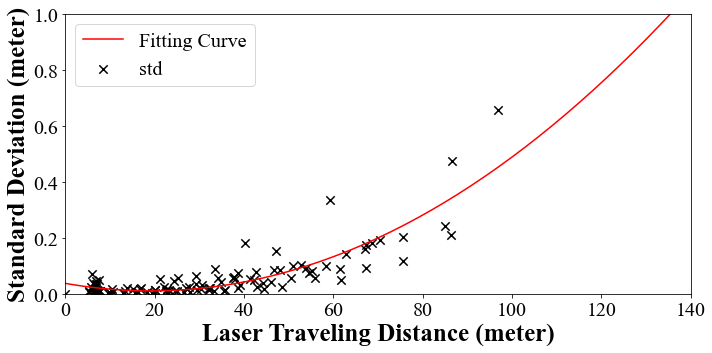

In [33]:
plt.figure(figsize=(10,5))
plt.scatter(dis_Total,stds_Total, marker = 'x', c = 'black', label = 'std', s = 70)
plt.plot(x,y , c = 'r' , label = 'Fitting Curve')
plt.legend(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.xlim(0,140)
plt.ylim(0,1)
plt.xlabel('Laser Traveling Distance (meter)',fontsize = 25, fontweight = 'bold')
plt.ylabel('Standard Deviation (meter)',fontsize = 25, fontweight = 'bold')
plt.tight_layout()
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\distance.tif',dpi = 600)
plt.show()

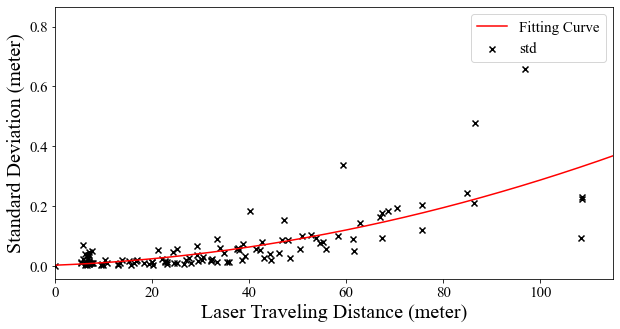

In [6]:
plt.figure(figsize=(10,5))
plt.scatter(dis_Total,stds_Total, marker = 'x', c = 'black', label = 'std')
plt.plot(x,y , c = 'r' , label = 'Fitting Curve')
plt.xlim(0,115)
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel('Laser Traveling Distance (meter)',fontsize = 20)
plt.ylabel('Standard Deviation (meter)',fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\distance.tif',dpi = 600)
plt.show()

In [61]:
x = np.arange(1,140,10)
y = popt[0] * x**2 + popt[1] * x + popt[2]

In [32]:
f_path = r'D:\LiDAR_Data\AmplitudeTest\Liberty\Snowy'
path_amp = os.listdir(f_path)
dis_Liberty = []
amps = []
for p in path_amp:
    test = np.load(os.path.join(f_path,p))
    dis_Liberty.append(eval(p[:-4]))
    amps.append(test)
stds_Liberty = np.array([a.std() for a in amps])
# means = [a.mean() for a in amps]
lenths_Liberty = np.array([len(a) for a in amps])
dis_Liberty = np.array(dis_Liberty)
f_path = r'D:\LiDAR_Data\AmplitudeTest\Steward\Snowy'
path_amp = os.listdir(f_path)
dis_Steward = []
amps = []
for p in path_amp:
    test = np.load(os.path.join(f_path,p))
    dis_Steward.append(eval(p[:-4]))
    amps.append(test)
stds_Steward = np.array([a.std() for a in amps])
# means = [a.mean() for a in amps]
lenths_Steward = np.array([len(a) for a in amps])
dis_Steward = np.array(dis_Steward)
f_path = r'D:\LiDAR_Data\AmplitudeTest\California\Snowy'
path_amp = os.listdir(f_path)
dis_California = []
amps = []
for p in path_amp:
    test = np.load(os.path.join(f_path,p))
    dis_California.append(eval(p[:-4]))
    amps.append(test)
stds_California = np.array([a.std() for a in amps])
lenths_California = np.array([len(a) for a in amps])
dis_California = np.array(dis_California)

In [23]:
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * np.e**x + b 

In [28]:
popt, pcov = curve_fit(func, total_dis, total_std)
x = np.arange(0,180)
y = popt[0] * np.e**x + popt[1]

In [29]:
x = np.arange(0,180)
y = popt[0] * np.e**x + popt[1]

In [30]:
total_dis = np.concatenate([dis_Liberty,dis_Steward,dis_California])
total_std = np.concatenate([stds_Liberty,stds_Steward,stds_California])

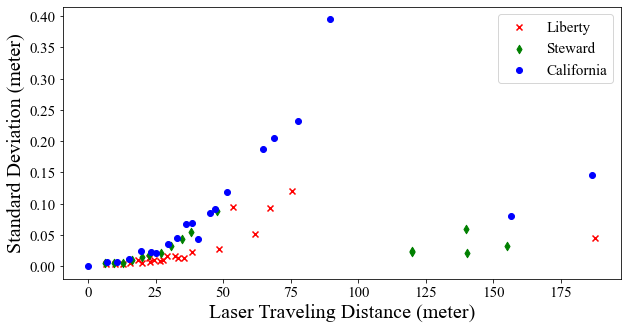

In [39]:
plt.figure(figsize=(10,5))
plt.scatter(dis_Liberty[lenths_Liberty > 10000],stds_Liberty[lenths_Liberty > 10000], marker = 'x', c = 'r',label = 'Liberty')
plt.scatter(dis_Steward[lenths_Steward > 10000],stds_Steward[lenths_Steward > 10000], marker = 'd', c = 'g',label = 'Steward')
plt.scatter(dis_California[lenths_California > 10000],stds_California[lenths_California > 10000], marker = 'o', c = 'b',label = 'California')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
# plt.plot(x,y)
# plt.ylim(0,0.3)
plt.xlabel('Laser Traveling Distance (meter)',fontsize = 20)
plt.ylabel('Standard Deviation (meter)',fontsize = 20)
plt.show()

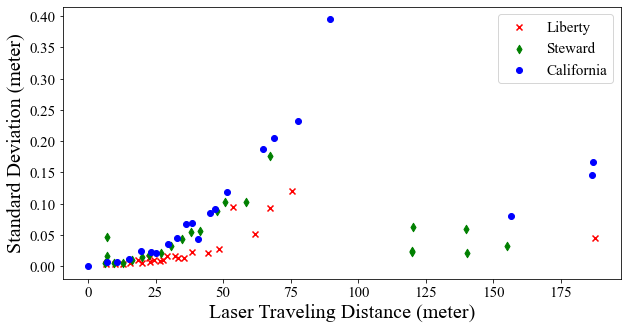

In [36]:
f_path = r'D:\LiDAR_Data\AmplitudeTest\Liberty\Normal'
path_amp = os.listdir(f_path)
dis_Liberty = []
amps = []
for p in path_amp:
    test = np.load(os.path.join(f_path,p))
    dis_Liberty.append(eval(p[:-4]))
    amps.append(test)
stds_Liberty = np.array([a.std() for a in amps])
# means = [a.mean() for a in amps]
lenths_Liberty = np.array([len(a) for a in amps])
dis_Liberty = np.array(dis_Liberty)
f_path = r'D:\LiDAR_Data\AmplitudeTest\Steward\Normal'
path_amp = os.listdir(f_path)
dis_Steward = []
amps = []
for p in path_amp:
    test = np.load(os.path.join(f_path,p))
    dis_Steward.append(eval(p[:-4]))
    amps.append(test)
stds_Steward = np.array([a.std() for a in amps])
# means = [a.mean() for a in amps]
lenths_Steward = np.array([len(a) for a in amps])
dis_Steward = np.array(dis_Steward)
f_path = r'D:\LiDAR_Data\AmplitudeTest\California\Normal'
path_amp = os.listdir(f_path)
dis_California = []
amps = []
for p in path_amp:
    test = np.load(os.path.join(f_path,p))
    dis_California.append(eval(p[:-4]))
    amps.append(test)
stds_California = np.array([a.std() for a in amps])
lenths_California = np.array([len(a) for a in amps])
dis_California = np.array(dis_California)
plt.figure(figsize=(10,5))
plt.scatter(dis_Liberty[lenths_Liberty > 8000],stds_Liberty[lenths_Liberty > 8000], marker = 'x', c = 'r',label = 'Liberty')
plt.scatter(dis_Steward[lenths_Steward > 8000],stds_Steward[lenths_Steward > 8000], marker = 'd', c = 'g',label = 'Steward')
plt.scatter(dis_California[lenths_California > 8000],stds_California[lenths_California > 8000], marker = 'o', c = 'b',label = 'California')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
# plt.plot(x,y)
# plt.ylim(0,0.3)
plt.xlabel('Laser Traveling Distance (meter)',fontsize = 20)
plt.ylabel('Standard Deviation (meter)',fontsize = 20)
plt.show()

In [703]:
temp = amps[5].copy()
temp = temp[temp < 160]

In [705]:
np.save(r'D:\LiDAR_Data\AmplitudeTest\California\Normal\{}.npy'.format(dis[5]),temp)

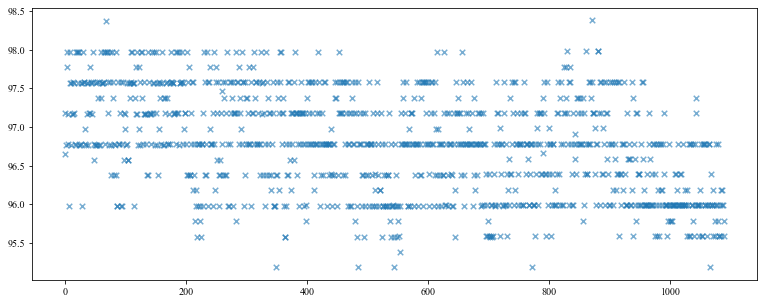

In [724]:
plt.figure(figsize=(13,5))
plt.scatter(np.arange(len(amps[36])),amps[36],s = 30, marker = 'x', label = "Background", alpha = 0.6)

In [80]:
vol_weekday = pd.read_csv(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Data\weekday.csv')
vol_weekend = pd.read_csv(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Data\weekend.csv')

In [81]:
SB_weekday = np.array(vol_weekday.S)/3600
NB_weekday = np.array(vol_weekday.N)/3600

In [82]:
SB_weekend = np.array(vol_weekend.S)/3600
NB_weekend = np.array(vol_weekend.N)/3600

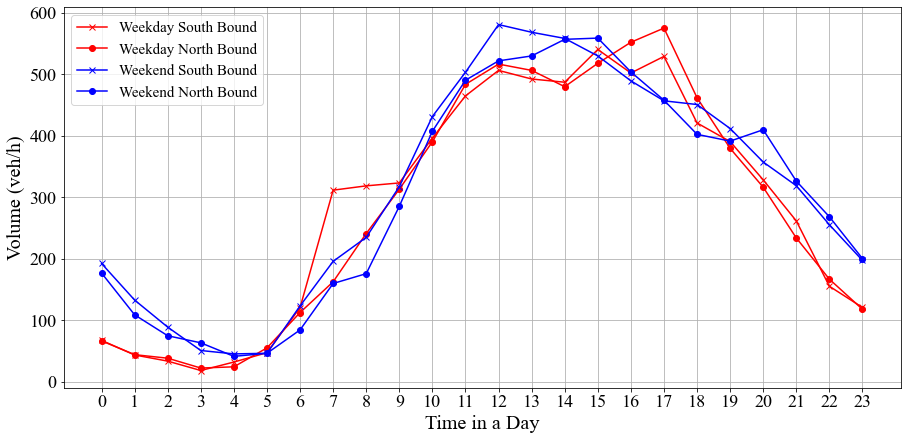

In [4]:
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(vol_weekday.S, c = 'r', marker = 'x', label = 'Weekday South Bound')
plt.plot(vol_weekday.N, c = 'r', marker = 'o', label = 'Weekday North Bound')
plt.plot(vol_weekend.S, c = 'b', marker = 'x', label = 'Weekend South Bound')
plt.plot(vol_weekend.N, c = 'b', marker = 'o', label = 'Weekend North Bound')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Volume (veh/h)',fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\volumes.tif',dpi = 300)
plt.show()

In [17]:
f_path = r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Data\Result_WeekEnd'
foregrounds_NBTD = []
p_f_NBTD = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_NBTD.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 34)]
    foregrounds_NBTD.append(fore)
    p_f_NBTD.append(len(fore)/len(temp))
foregrounds_NBTU = []
p_f_NBTU = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_NBTU.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 12.5)]
    foregrounds_NBTU.append(fore)
    p_f_NBTU.append(len(fore)/len(temp))
foregrounds_SBTU = []
p_f_SBTU = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_SBTU.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 35)]
    foregrounds_NBTU.append(fore)
    p_f_SBTU.append(len(fore)/len(temp))
foregrounds_SBTD = []
p_f_SBTD = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_SBTD.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 20)]
    p_f_SBTD.append(len(fore)/len(temp))

In [110]:
speed = 20.2*1000/3600
ro_SBTU_weekend = 5*(SB_weekend/speed)
speed = 30.3*1000/3600
ro_SBTD_weekend = 5*(SB_weekend/speed)

In [77]:
np.abs((ro_SBTD_weekend - p_f_SBTD)).sum()/24

0.009984922673482699

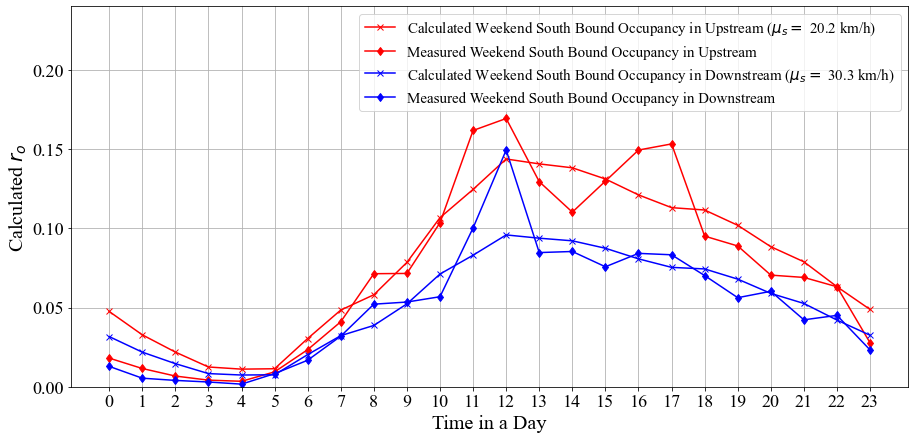

In [111]:
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(ro_SBTU_weekend, c = 'r', marker = 'x', label = 'Calculated Weekend South Bound Occupancy in Upstream ($ \mathit{\mu_s} = $ 20.2 km/h)')
plt.plot(p_f_SBTU, c = 'r', marker = 'd', label = 'Measured Weekend South Bound Occupancy in Upstream')
plt.plot(ro_SBTD_weekend, c = 'b', marker = 'x', label = 'Calculated Weekend South Bound Occupancy in Downstream ($ \mathit{\mu_s} = $ 30.3 km/h)')
plt.plot(p_f_SBTD, c = 'b', marker = 'd', label = 'Measured Weekend South Bound Occupancy in Downstream')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.24)
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Calculated $r_o$ ',fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roSB_weekend.tif',dpi = 300)
plt.show()

In [78]:
np.abs((ro_NBTD_weekend - p_f_NBTD)).sum()/24

0.009536208469823408

In [79]:
np.abs((ro_NBTU_weekend - p_f_NBTU)).sum()/24

0.026884370694428766

In [83]:
speed = 13.8*1000/3600
ro_NBTU_weekend = 5*(NB_weekend/speed)
speed = 34.1*1000/3600
ro_NBTD_weekend = 5*(NB_weekend/speed)

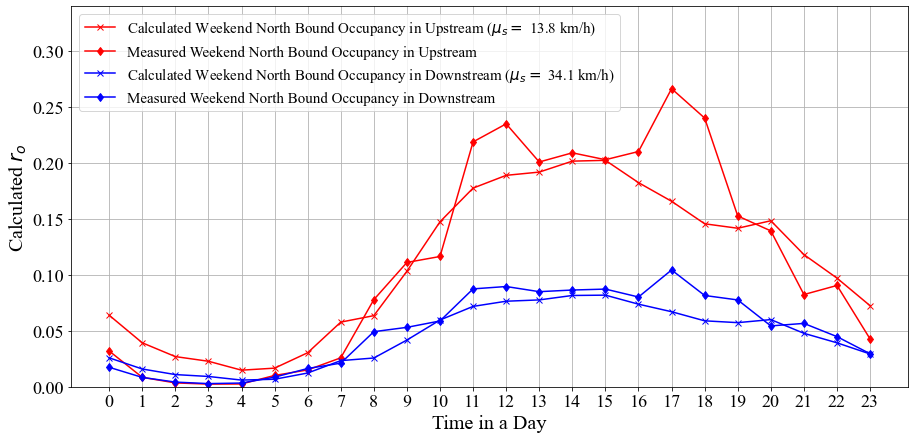

In [109]:
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(ro_NBTU_weekend, c = 'r', marker = 'x', label = 'Calculated Weekend North Bound Occupancy in Upstream ($ \mathit{\mu_s} = $ 13.8 km/h)')
plt.plot(p_f_NBTU, c = 'r', marker = 'd', label = 'Measured Weekend North Bound Occupancy in Upstream')
plt.plot(ro_NBTD_weekend, c = 'b', marker = 'x', label = 'Calculated Weekend North Bound Occupancy in Downstream ($ \mathit{\mu_s} = $ 34.1 km/h)')
plt.plot(p_f_NBTD, c = 'b', marker = 'd', label = 'Measured Weekend North Bound Occupancy in Downstream')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.34)
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Calculated $r_o$',fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roNB_weekend.tif',dpi = 300)

plt.show()

In [4]:
f_path = r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Data\Result_WeekDay'
foregrounds_NBTD = []
p_f_NBTD = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_NBTD.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 34)]
    foregrounds_NBTD.append(fore)
    p_f_NBTD.append(len(fore)/len(temp))
foregrounds_NBTU = []
p_f_NBTU = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_NBTU.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 12.5)]
    foregrounds_NBTU.append(fore)
    p_f_NBTU.append(len(fore)/len(temp))
foregrounds_SBTU = []
p_f_SBTU = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_SBTU.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 35)]
    foregrounds_NBTU.append(fore)
    p_f_SBTU.append(len(fore)/len(temp))
foregrounds_SBTD = []
p_f_SBTD = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_SBTD.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 20)]
    p_f_SBTD.append(len(fore)/len(temp))

In [84]:
speed = 21.5*1000/3600
ro_SBTU_weekday = 5*(SB_weekday/speed)
speed = 30.6*1000/3600
ro_SBTD_weekday = 5*(SB_weekday/speed)

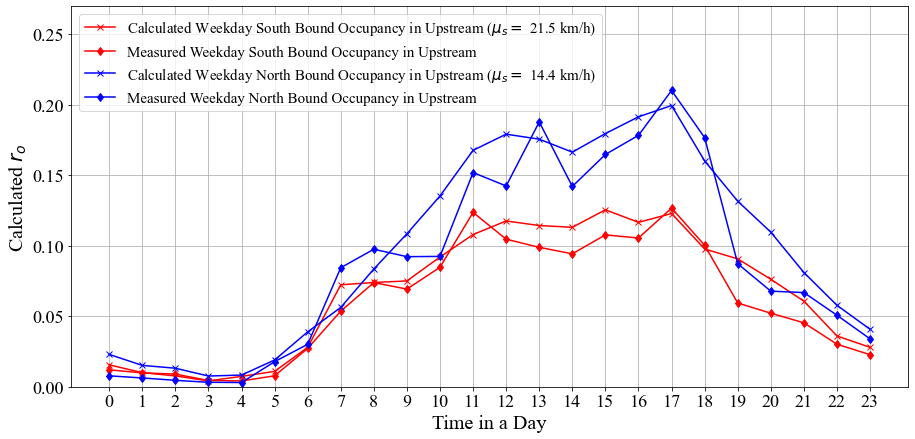

In [18]:
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(ro_SBTU_weekday, c = 'r', marker = 'x', label = 'Calculated Weekday South Bound Occupancy in Upstream ($ \mathit{\mu_s} = $ 21.5 km/h)')
plt.plot(p_f_SBTU, c = 'r', marker = 'd', label = 'Measured Weekday South Bound Occupancy in Upstream')
plt.plot(ro_NBTU_weekday, c = 'b', marker = 'x', label = 'Calculated Weekday North Bound Occupancy in Upstream ($ \mathit{\mu_s} = $ 14.4 km/h)')
plt.plot(p_f_NBTU, c = 'b', marker = 'd', label = 'Measured Weekday North Bound Occupancy in Upstream')
# plt.plot(ro_SBTD_weekday, c = 'b', marker = 'x', label = 'Calculated Weekday South Bound Occupancy in Downstream ($ \mathit{\mu_s} = $ 30.6 km/h)')
# plt.plot(p_f_SBTD, c = 'b', marker = 'd', label = 'Measured Weekday South Bound Occupancy in Downstream')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.27)
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Calculated $r_o$ ',fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\ro_final.tif',dpi = 300)
plt.show()

In [85]:
speed = 14.4*1000/3600
ro_NBTU_weekday = 5*(NB_weekday/speed)
speed = 34.6*1000/3600
ro_NBTD_weekday = 5*(NB_weekday/speed)

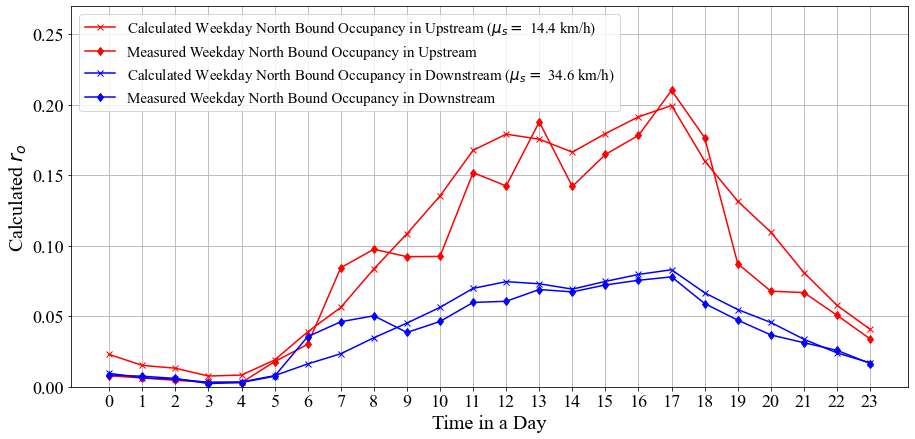

In [116]:

plt.figure(figsize=(15,7))
plt.grid()
plt.plot(ro_NBTU_weekday, c = 'r', marker = 'x', label = 'Calculated Weekday North Bound Occupancy in Upstream ($ \mathit{\mu_s} = $ 14.4 km/h)')
plt.plot(p_f_NBTU, c = 'r', marker = 'd', label = 'Measured Weekday North Bound Occupancy in Upstream')
plt.plot(ro_NBTD_weekday, c = 'b', marker = 'x', label = 'Calculated Weekday North Bound Occupancy in Downstream ($ \mathit{\mu_s} = $ 34.6 km/h)')
plt.plot(p_f_NBTD, c = 'b', marker = 'd', label = 'Measured Weekday North Bound Occupancy in Downstream')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.27)
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Calculated $r_o$ ',fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roNB_weekday.tif',dpi = 300)
plt.show()

In [98]:
f_path = r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Data\Result_WeekEnd'
foregrounds_NBTD = []
p_f_NBTD = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_NBTD.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 34)]
    foregrounds_NBTD.append(fore)
    p_f_NBTD.append(len(fore)/len(temp))
foregrounds_NBTU = []
p_f_NBTU = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_NBTU.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 12.5)]
    foregrounds_NBTU.append(fore)
    p_f_NBTU.append(len(fore)/len(temp))
foregrounds_SBTU = []
p_f_SBTU = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_SBTU.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 35)]
    foregrounds_NBTU.append(fore)
    p_f_SBTU.append(len(fore)/len(temp))
foregrounds_SBTD = []
p_f_SBTD = []
for t in range(0,24):
    temp = np.load(os.path.join(f_path,'{}_SBTD.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 20)]
    p_f_SBTD.append(len(fore)/len(temp))

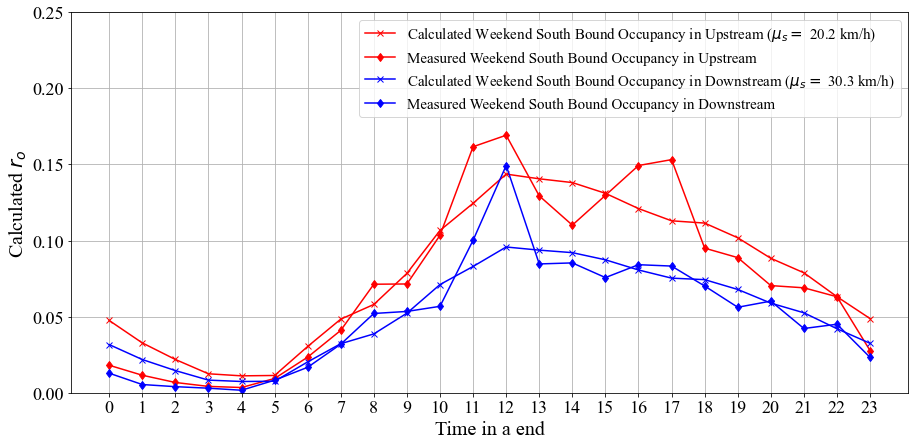

In [103]:
speed = 20.2*1000/3600
ro_SBTU_weekend = 5*(SB_weekend/speed)
speed = 30.3*1000/3600
ro_SBTD_weekend = 5*(SB_weekend/speed)
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(ro_SBTU_weekend, c = 'r', marker = 'x', label = 'Calculated Weekend South Bound Occupancy in Upstream ($ \mathit{\mu_s} = $ 20.2 km/h)')
plt.plot(p_f_SBTU, c = 'r', marker = 'd', label = 'Measured Weekend South Bound Occupancy in Upstream')
plt.plot(ro_SBTD_weekend, c = 'b', marker = 'x', label = 'Calculated Weekend South Bound Occupancy in Downstream ($ \mathit{\mu_s} = $ 30.3 km/h)')
plt.plot(p_f_SBTD, c = 'b', marker = 'd', label = 'Measured Weekend South Bound Occupancy in Downstream')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.25)
plt.xlabel('Time in a end',fontsize = 20)
plt.ylabel('Calculated $r_o$ ',fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roSB_weekend.tif',dpi = 300)
plt.show()

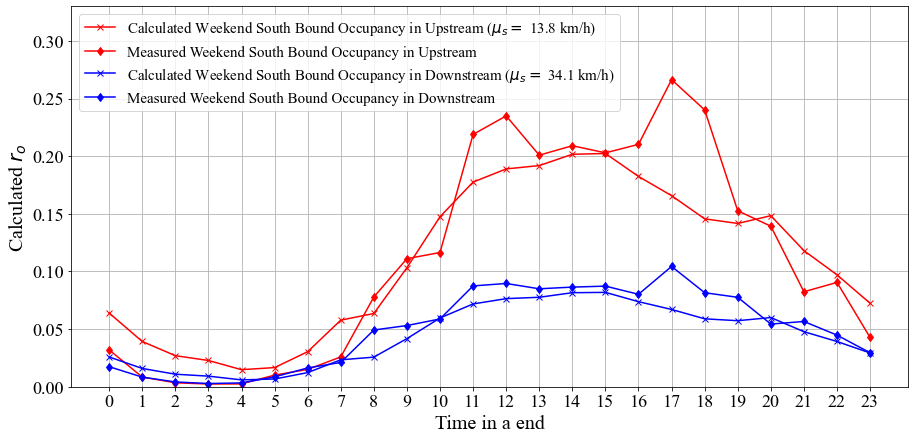

In [107]:
speed = 13.8*1000/3600
ro_NBTU_weekend = 5*(NB_weekend/speed)
speed = 34.1*1000/3600
ro_NBTD_weekend = 5*(NB_weekend/speed)
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(ro_NBTU_weekend, c = 'r', marker = 'x', label = 'Calculated Weekend South Bound Occupancy in Upstream ($ \mathit{\mu_s} = $ 13.8 km/h)')
plt.plot(p_f_NBTU, c = 'r', marker = 'd', label = 'Measured Weekend South Bound Occupancy in Upstream')
plt.plot(ro_NBTD_weekend, c = 'b', marker = 'x', label = 'Calculated Weekend South Bound Occupancy in Downstream ($ \mathit{\mu_s} = $ 34.1 km/h)')
plt.plot(p_f_NBTD, c = 'b', marker = 'd', label = 'Measured Weekend South Bound Occupancy in Downstream')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.33)
plt.xlabel('Time in a end',fontsize = 20)
plt.ylabel('Calculated $r_o$ ',fontsize = 20)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roNB_weekend.tif',dpi = 300)
plt.show()

In [19]:
c_f = 0.16

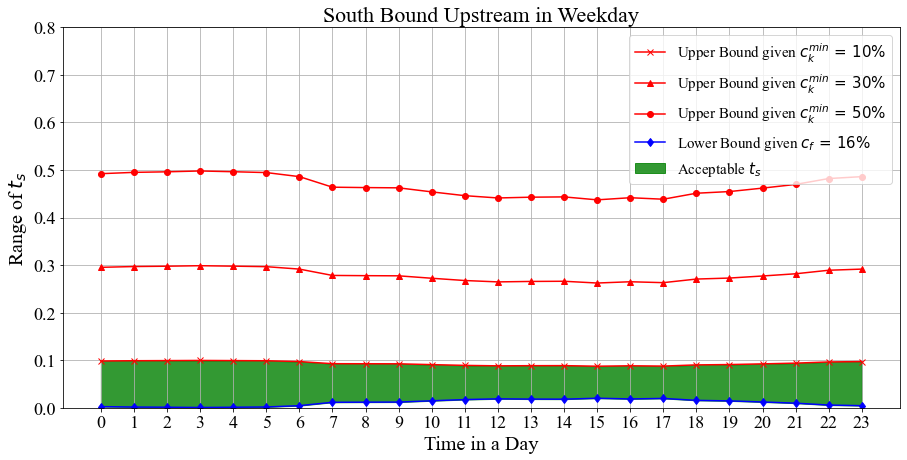

In [20]:
ro_SBTU_weekday
lower_SBTU_weekday = c_f * ro_SBTU_weekday
upper_SBTU_weekday_1 = 0.1*(1 - ro_SBTU_weekday)
upper_SBTU_weekday_3 = 0.3*(1 - ro_SBTU_weekday)
upper_SBTU_weekday_5 = 0.5*(1 - ro_SBTU_weekday)
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(upper_SBTU_weekday_1, c = 'r', marker = 'x', label = 'Upper Bound given $c_k^{min}\/=\/10\%$')
plt.plot(upper_SBTU_weekday_3, c = 'r', marker = '^', label = 'Upper Bound given $c_k^{min}\/=\/30\%$')
plt.plot(upper_SBTU_weekday_5, c = 'r', marker = 'o', label = 'Upper Bound given $c_k^{min}\/=\/50\%$')
plt.plot(lower_SBTU_weekday, c = 'b', marker = 'd', label = 'Lower Bound given $c_f\/=\/16\%$ ')
plt.fill_between(np.arange(24),upper_SBTU_weekday_1,lower_SBTU_weekday, color = 'g', label = 'Acceptable $t_s$',alpha = 0.8)
plt.legend(fontsize = 15, loc = 'upper right')
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.8)
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Range of $t_s$ ',fontsize = 20)
plt.title('South Bound Upstream in Weekday', fontsize = 22)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roSBTU_ts_weekday.tif',dpi = 300)
plt.show()

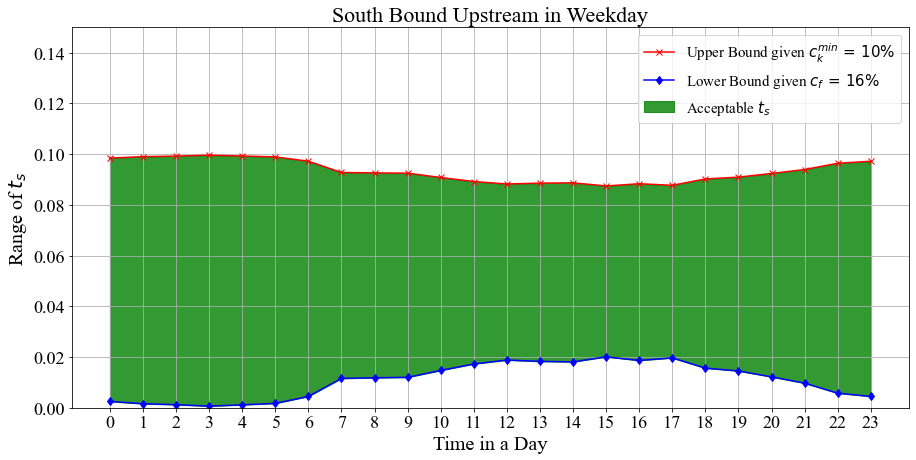

In [21]:
ro_SBTU_weekday
lower_SBTU_weekday = c_f * ro_SBTU_weekday
upper_SBTU_weekday_1 = 0.1*(1 - ro_SBTU_weekday)
upper_SBTU_weekday_3 = 0.3*(1 - ro_SBTU_weekday)
upper_SBTU_weekday_5 = 0.5*(1 - ro_SBTU_weekday)
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(upper_SBTU_weekday_1, c = 'r', marker = 'x', label = 'Upper Bound given $c_k^{min}\/=\/10\%$')
# plt.plot(upper_SBTU_weekday_3, c = 'r', marker = '^', label = 'Upper Bound given $c_k^{min}\/=\/30\%$')
# plt.plot(upper_SBTU_weekday_5, c = 'r', marker = 'o', label = 'Upper Bound given $c_k^{min}\/=\/50\%$')
plt.plot(lower_SBTU_weekday, c = 'b', marker = 'd', label = 'Lower Bound given $c_f\/=\/16\%$ ')
plt.fill_between(np.arange(24),upper_SBTU_weekday_1,lower_SBTU_weekday, color = 'g', label = 'Acceptable $t_s$',alpha = 0.8)
plt.legend(fontsize = 15, loc = 'upper right')
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.15)
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Range of $t_s$ ',fontsize = 20)
plt.title('South Bound Upstream in Weekday', fontsize = 22)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roSBTU_ts_weekday_zoomin.tif',dpi = 300)
plt.show()

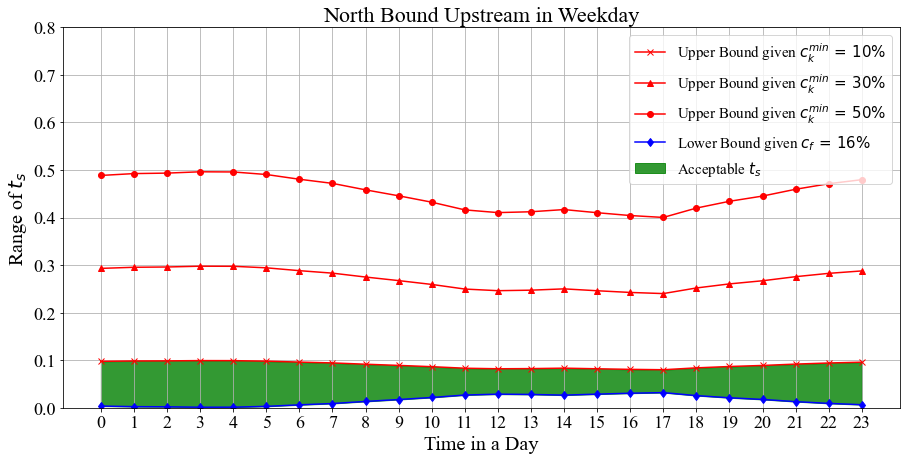

In [22]:
ro_NBTU_weekday
lower_NBTU_weekday = c_f * ro_NBTU_weekday
upper_NBTU_weekday_1 = 0.1*(1 - ro_NBTU_weekday)
upper_NBTU_weekday_3 = 0.3*(1 - ro_NBTU_weekday)
upper_NBTU_weekday_5 = 0.5*(1 - ro_NBTU_weekday)
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(upper_NBTU_weekday_1, c = 'r', marker = 'x', label = 'Upper Bound given $c_k^{min}\/=\/10\%$')
plt.plot(upper_NBTU_weekday_3, c = 'r', marker = '^', label = 'Upper Bound given $c_k^{min}\/=\/30\%$')
plt.plot(upper_NBTU_weekday_5, c = 'r', marker = 'o', label = 'Upper Bound given $c_k^{min}\/=\/50\%$')
plt.plot(lower_NBTU_weekday, c = 'b', marker = 'd', label = 'Lower Bound given $c_f\/=\/16\%$ ')
plt.fill_between(np.arange(24),upper_NBTU_weekday_1,lower_NBTU_weekday, color = 'g', label = 'Acceptable $t_s$',alpha = 0.8)
plt.legend(fontsize = 15, loc = 'upper right')
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.8)
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Range of $t_s$ ',fontsize = 20)
plt.title('North Bound Upstream in Weekday', fontsize = 22)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roNBTU_ts_weekday.tif',dpi = 300)
plt.show()

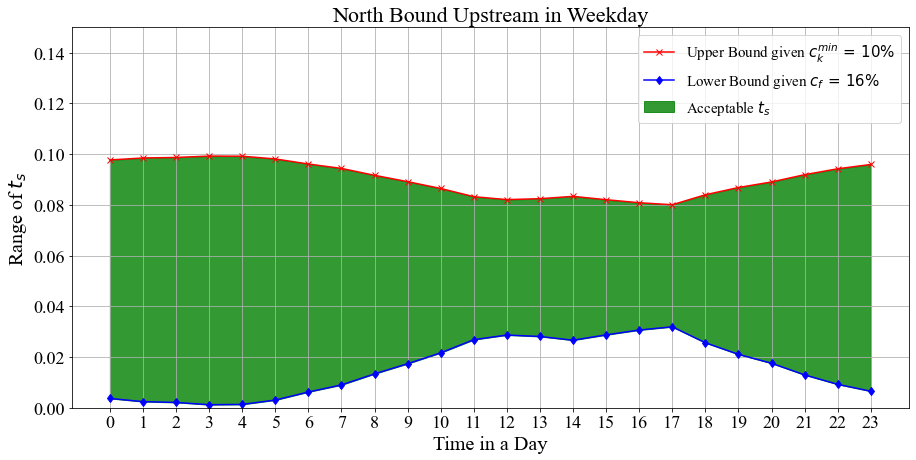

In [23]:
ro_NBTU_weekday
lower_NBTU_weekday = c_f * ro_NBTU_weekday
upper_NBTU_weekday_1 = 0.1*(1 - ro_NBTU_weekday)
upper_NBTU_weekday_3 = 0.3*(1 - ro_NBTU_weekday)
upper_NBTU_weekday_5 = 0.5*(1 - ro_NBTU_weekday)
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(upper_NBTU_weekday_1, c = 'r', marker = 'x', label = 'Upper Bound given $c_k^{min}\/=\/10\%$')
# plt.plot(upper_NBTU_weekday_3, c = 'r', marker = '^', label = 'Upper Bound given $c_k^{min}\/=\/30\%$')
# plt.plot(upper_NBTU_weekday_5, c = 'r', marker = 'o', label = 'Upper Bound given $c_k^{min}\/=\/50\%$')
plt.plot(lower_NBTU_weekday, c = 'b', marker = 'd', label = 'Lower Bound given $c_f\/=\/16\%$ ')
plt.fill_between(np.arange(24),upper_NBTU_weekday_1,lower_NBTU_weekday, color = 'g', label = 'Acceptable $t_s$',alpha = 0.8)
plt.legend(fontsize = 15, loc = 'upper right')
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.ylim(0,0.15)
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Range of $t_s$ ',fontsize = 20)
plt.title('North Bound Upstream in Weekday', fontsize = 22)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roNBTU_ts_weekday_zoomin.tif',dpi = 300)
plt.show()

In [20]:
adopted_ts

array([0.0506901 , 0.05045573, 0.05039583, 0.05022917, 0.05025   ,
       0.05057031, 0.05116927, 0.05217151, 0.05250781, 0.05325781,
       0.0540625 , 0.05503385, 0.0553776 , 0.05527083, 0.05499479,
       0.05539062, 0.0557474 , 0.05598698, 0.05480729, 0.05395052,
       0.05329167, 0.05243229, 0.05173437, 0.05122396])

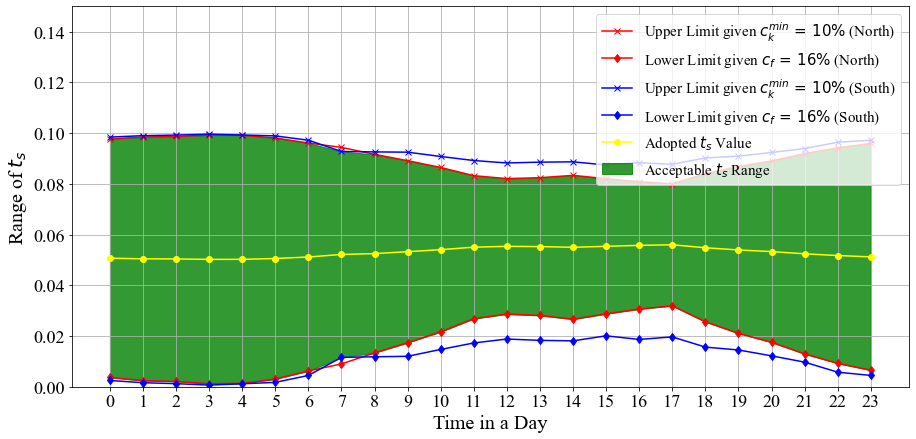

In [87]:
c_f = 0.16
lower_NBTU_weekday = c_f * ro_NBTU_weekday
upper_NBTU_weekday_1 = 0.1*(1 - ro_NBTU_weekday)
lower_SBTU_weekday = c_f * ro_SBTU_weekday
upper_SBTU_weekday_1 = 0.1*(1 - ro_SBTU_weekday)
ts_region_upper = []
for i in range(len(upper_NBTU_weekday_1)):
    if upper_NBTU_weekday_1[i] < upper_SBTU_weekday_1[i]:
        ts_region_upper.append(upper_NBTU_weekday_1[i])
    else:
        ts_region_upper.append(upper_SBTU_weekday_1[i])
ts_region_lower = []
for i in range(len(lower_NBTU_weekday)):
    if lower_SBTU_weekday[i] < lower_NBTU_weekday[i]:
        ts_region_lower.append(lower_NBTU_weekday[i])
    else:
        ts_region_lower.append(lower_SBTU_weekday[i])      
adopted_ts = (np.array(ts_region_lower) + np.array(ts_region_upper))/2
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(upper_NBTU_weekday_1, c = 'r', marker = 'x', label = 'Upper Limit given $c_k^{min}\/=\/10\%$ (North)')
plt.plot(lower_NBTU_weekday, c = 'r', marker = 'd', label = 'Lower Limit given $c_f\/=\/16\%$ (North)')
plt.plot(upper_SBTU_weekday_1, c = 'b', marker = 'x', label = 'Upper Limit given $c_k^{min}\/=\/10\%$ (South)')
plt.plot(lower_SBTU_weekday, c = 'b', marker = 'd', label = 'Lower Limit given $c_f\/=\/16\%$ (South)')
plt.fill_between(np.arange(24),ts_region_upper,ts_region_lower, color = 'g', label = 'Acceptable $t_s$ Range',alpha = 0.8)
plt.plot(adopted_ts, marker = 'o',c  = 'yellow', label = 'Adopted $t_s$ Value')
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Range of $t_s$ ',fontsize = 20)
plt.ylim(0,0.15)
plt.legend(fontsize = 15,)
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\FinalTs.tif',dpi = 300)

plt.show()

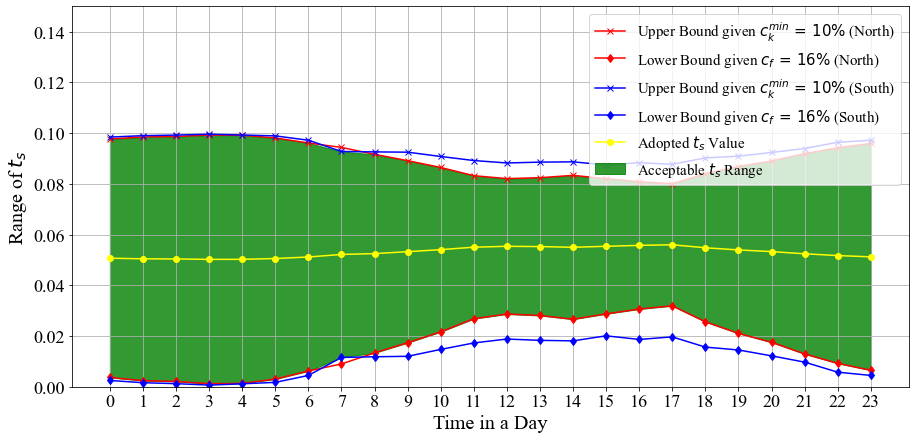

In [19]:
c_f = 0.16
lower_NBTU_weekday = c_f * ro_NBTU_weekday
upper_NBTU_weekday_1 = 0.1*(1 - ro_NBTU_weekday)
lower_SBTU_weekday = c_f * ro_SBTU_weekday
upper_SBTU_weekday_1 = 0.1*(1 - ro_SBTU_weekday)
ts_region_upper = []
for i in range(len(upper_NBTU_weekday_1)):
    if upper_NBTU_weekday_1[i] < upper_SBTU_weekday_1[i]:
        ts_region_upper.append(upper_NBTU_weekday_1[i])
    else:
        ts_region_upper.append(upper_SBTU_weekday_1[i])
ts_region_lower = []
for i in range(len(lower_NBTU_weekday)):
    if lower_SBTU_weekday[i] < lower_NBTU_weekday[i]:
        ts_region_lower.append(lower_NBTU_weekday[i])
    else:
        ts_region_lower.append(lower_SBTU_weekday[i])      
adopted_ts = (np.array(ts_region_lower) + np.array(ts_region_upper))/2
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(upper_NBTU_weekday_1, c = 'r', marker = 'x', label = 'Upper Bound given $c_k^{min}\/=\/10\%$ (North)')
plt.plot(lower_NBTU_weekday, c = 'r', marker = 'd', label = 'Lower Bound given $c_f\/=\/16\%$ (North)')
plt.plot(upper_SBTU_weekday_1, c = 'b', marker = 'x', label = 'Upper Bound given $c_k^{min}\/=\/10\%$ (South)')
plt.plot(lower_SBTU_weekday, c = 'b', marker = 'd', label = 'Lower Bound given $c_f\/=\/16\%$ (South)')
plt.fill_between(np.arange(24),ts_region_upper,ts_region_lower, color = 'g', label = 'Acceptable $t_s$ Range',alpha = 0.8)
plt.plot(adopted_ts, marker = 'o',c  = 'yellow', label = 'Adopted $t_s$ Value')
plt.xlabel('Time in a Day',fontsize = 20)
plt.ylabel('Range of $t_s$ ',fontsize = 20)
plt.ylim(0,0.15)
plt.legend(fontsize = 15,)
plt.yticks(fontsize = 18)
plt.xticks(np.arange(0,24),fontsize = 18)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\FinalTs.tif',dpi = 300)

plt.show()

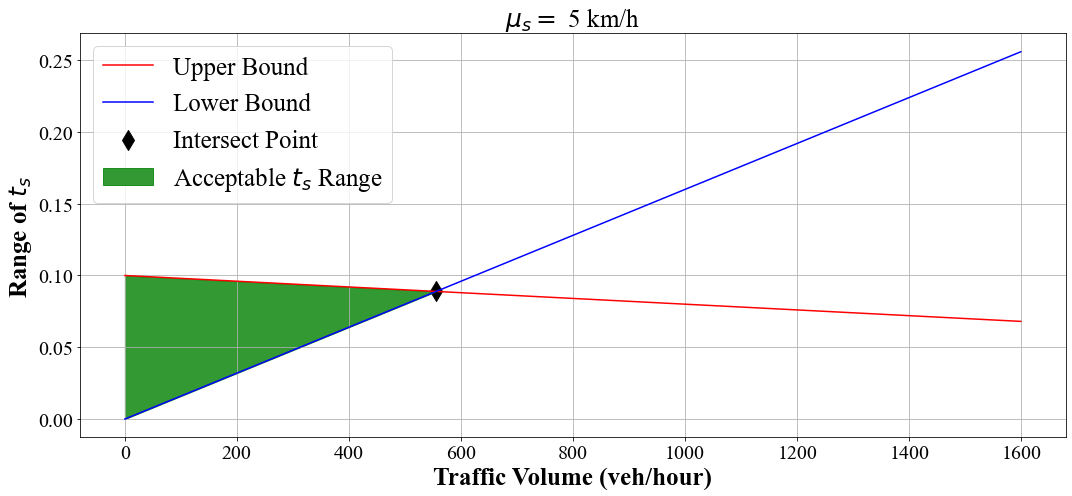

In [61]:
vkm = 5
v = vkm*1000/3600
L = 5
cf = 0.16
q = np.arange(0,1600,1)/3600
ckmin = 0.1
lower_bound = cf * L * q / v 
upper_bound = ckmin * (1 - q/v)
x_lim = ckmin*v/(cf*L +ckmin)* 3600
y_lim = cf * L * ckmin /(cf*L + ckmin)
plt.figure(figsize=(15,7))
plt.grid()
plt.scatter(x_lim ,y_lim, c = 'black', s = 200, marker = 'd',label = 'Intersect Point')
plt.plot(upper_bound, c = 'r' ,label = 'Upper Bound')
plt.plot(lower_bound, c = 'b', label = 'Lower Bound')
plt.fill_between(np.arange(0,int(x_lim)),upper_bound[:int(x_lim)],lower_bound[:int(x_lim)], color = 'g', label = 'Acceptable $t_s$ Range',alpha = 0.8)
plt.xlabel('Traffic Volume (veh/hour)',fontsize = 25, fontweight = 'bold')
plt.ylabel('Range of $t_s$ ',fontsize = 25, fontweight = 'bold')
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.legend(fontsize = 25)
plt.title(r'$ \mathit{\mu_s} = $ 5 km/h', fontsize = 25)
plt.tight_layout()
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\FinalTs_5.tif',dpi = 600)


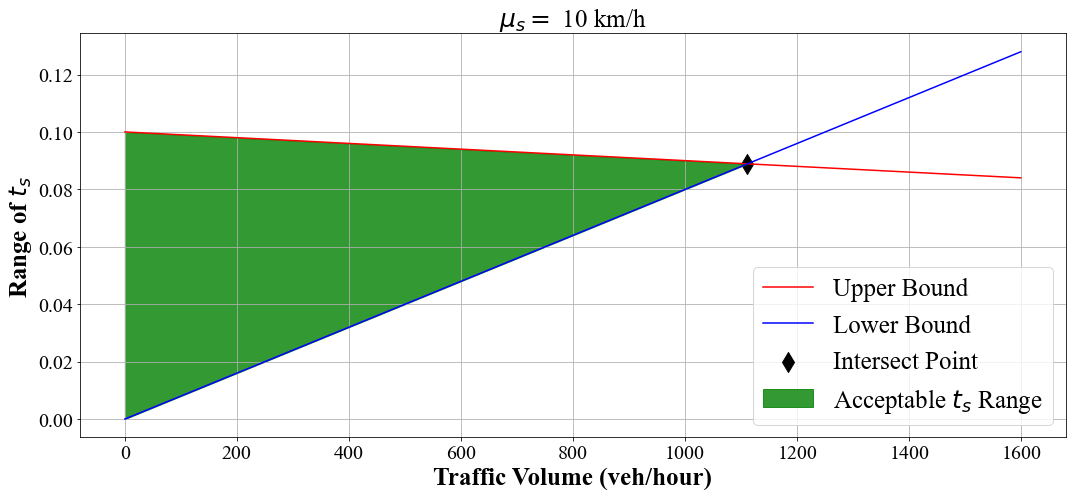

In [62]:
vkm = 10
v = vkm*1000/3600
L = 5
cf = 0.16
q = np.arange(0,1600,1)/3600
ckmin = 0.1
lower_bound = cf * L * q / v 
upper_bound = ckmin * (1 - q/v)
x_lim = ckmin*v/(cf*L +ckmin)* 3600
y_lim = cf * L * ckmin /(cf*L + ckmin)
plt.figure(figsize=(15,7))
plt.grid()
plt.scatter(x_lim ,y_lim, c = 'black', s = 200, marker = 'd',label = 'Intersect Point')
plt.plot(upper_bound, c = 'r' ,label = 'Upper Bound')
plt.plot(lower_bound, c = 'b', label = 'Lower Bound')
plt.fill_between(np.arange(0,int(x_lim)),upper_bound[:int(x_lim)],lower_bound[:int(x_lim)], color = 'g', label = 'Acceptable $t_s$ Range',alpha = 0.8)
plt.xlabel('Traffic Volume (veh/hour)',fontsize = 25, fontweight = 'bold')
plt.ylabel('Range of $t_s$ ',fontsize = 25, fontweight = 'bold')
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.legend(fontsize = 25)
plt.title(r'$ \mathit{\mu_s} = $ 10 km/h', fontsize = 25)
plt.tight_layout()
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\FinalTs_10.tif',dpi = 600)


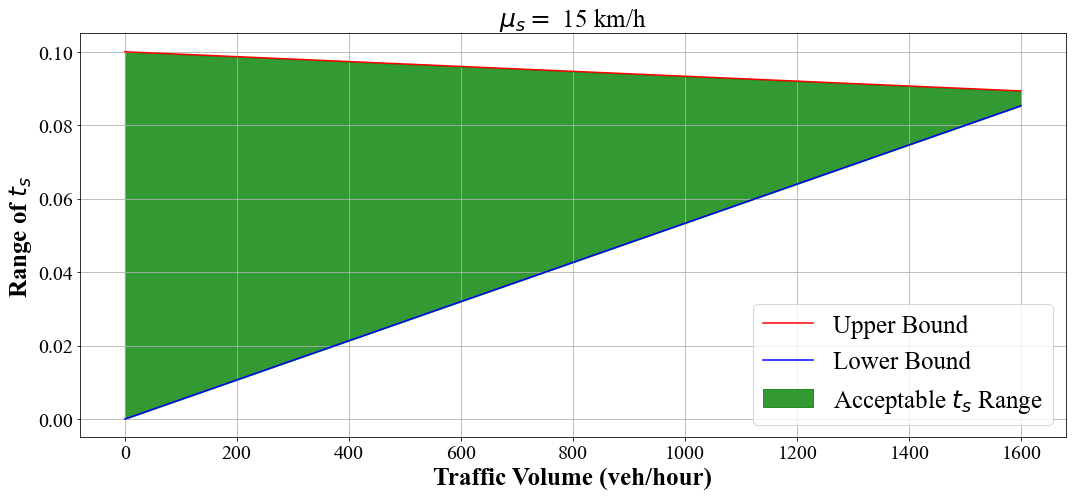

In [64]:
vkm = 15
v = vkm*1000/3600
L = 5
cf = 0.16
q = np.arange(0,1600,1)/3600
ckmin = 0.1
lower_bound = cf * L * q / v 
upper_bound = ckmin * (1 - q/v)
x_lim = ckmin*v/(cf*L +ckmin)* 3600
y_lim = cf * L * ckmin /(cf*L + ckmin)
plt.figure(figsize=(15,7))
plt.grid()
# plt.scatter(x_lim ,y_lim, c = 'black', s = 200, marker = 'd',label = 'Intersect Point')
plt.plot(upper_bound, c = 'r' ,label = 'Upper Bound')
plt.plot(lower_bound, c = 'b', label = 'Lower Bound')
plt.fill_between(np.arange(len(q)),upper_bound,lower_bound, color = 'g', label = 'Acceptable $t_s$ Range',alpha = 0.8)
plt.xlabel('Traffic Volume (veh/hour)',fontsize = 25, fontweight = 'bold')
plt.ylabel('Range of $t_s$ ',fontsize = 25, fontweight = 'bold')
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.legend(fontsize = 25)
plt.title(r'$ \mathit{\mu_s} = $ 15 km/h', fontsize = 25)
plt.tight_layout()
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\FinalTs_15.tif',dpi = 300)


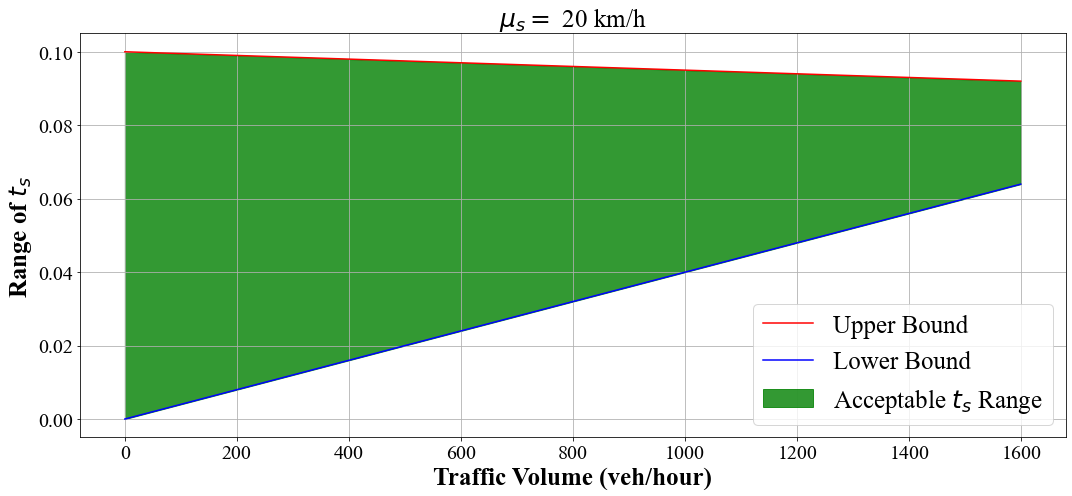

In [67]:
vkm = 20
v = vkm*1000/3600
L = 5
cf = 0.16
q = np.arange(0,1600,1)/3600
ckmin = 0.1
lower_bound = cf * L * q / v 
upper_bound = ckmin * (1 - q/v)
x_lim = ckmin*v/(cf*L +ckmin)* 3600
y_lim = cf * L * ckmin /(cf*L + ckmin)
plt.figure(figsize=(15,7))
plt.grid()
# plt.scatter(x_lim ,y_lim, c = 'black', s = 200, marker = 'd',label = 'Intersect Point')
plt.plot(upper_bound, c = 'r' ,label = 'Upper Bound')
plt.plot(lower_bound, c = 'b', label = 'Lower Bound')
plt.fill_between(np.arange(len(q)),upper_bound,lower_bound, color = 'g', label = 'Acceptable $t_s$ Range',alpha = 0.8)
plt.xlabel('Traffic Volume (veh/hour)',fontsize = 25, fontweight = 'bold')
plt.ylabel('Range of $t_s$ ',fontsize = 25, fontweight = 'bold')
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.legend(fontsize = 25)
plt.title(r'$ \mathit{\mu_s} = $ 20 km/h', fontsize = 25)
plt.tight_layout()
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\FinalTs_20.tif',dpi = 600)


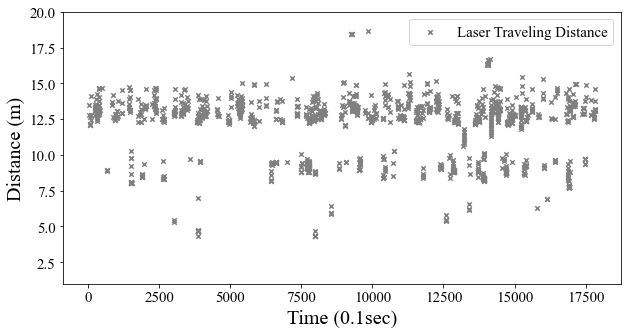

0.04416065951546039


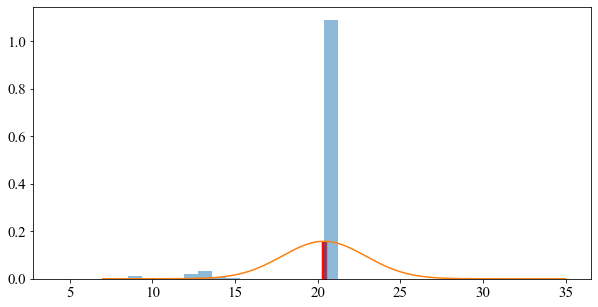

In [33]:
temp = np.load(os.path.join(f_path,'{}_SBTD.npy'.format(14)))
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 20, marker = 'x', label = "Laser Traveling Distance", c = 'gray')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)
fore = temp[(temp > 1)&(temp < 35.5)]
plt.ylim(1,20)
plt.show()
plt.figure(figsize=(10,5))
plt.hist(fore,density = True,bins = 20,alpha = 0.5)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
x = np.arange(7,35,0.01)
mean = fore.mean()
std = fore.std()
pdf = norm.pdf(x,mean, std)
ds = 0.07
cf = norm(loc = mean, scale = std).cdf(mean + 2*ds) - norm(loc = mean, scale = std).cdf(mean - 2*ds)
print(cf)
plt.plot(x, pdf)
ind = (x < (mean + 2*ds))&(x > (mean - 2*ds)) 
plt.fill_between(x[ind], pdf[ind],color = 'r')
plt.show()

In [10]:
cfs_sbtd = []
for t in range(24):
    temp = np.load(os.path.join(f_path,'{}_SBTD.npy'.format(t)))
    fore = temp[(temp > 1)&(temp < 20)]
    x = np.arange(7,14,0.01)
    mean = fore.mean()
    std = fore.std()
    pdf = norm.pdf(x,mean, std)
    ds = 0.07
    cf = norm(loc = mean, scale = std).cdf(mean + 2*ds) - norm(loc = mean, scale = std).cdf(mean - 2*ds)
    cfs_sbtd.append(cf)

In [11]:
total_cfs = cfs_nbtu + cfs_nbtd + cfs_sbtu + cfs_sbtd

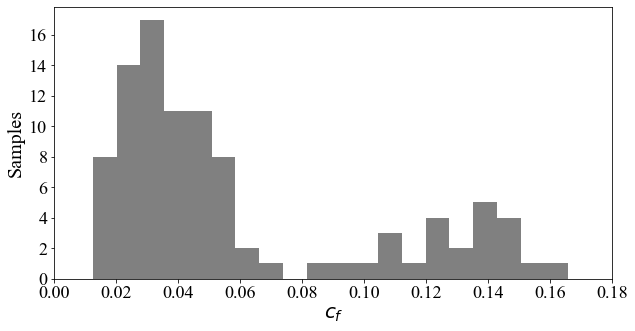

In [17]:
plt.figure(figsize=(10,5))
plt.hist(total_cfs, bins = 20, color = 'gray')
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.xlabel('$c_f$',fontsize = 20)
plt.ylabel('Samples',fontsize = 20)
plt.xlim(0,0.18)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\cf.tif',dpi = 300)
plt.show()

## Create Dataset 

In [ ]:
for i in range(len(aggregated_map)):
    a = np.random.rand()
    if a < 0.3:
        pcd = get_pcd_uncolored(aggregated_map[i])
        op3.io.write_point_cloud(r'D:\LiDAR_Data\MidTown\Stewart\TestSet\Stewart_21\{}'.format(f"{i:06d}.pcd"),pcd)

In [11]:
db = Raster_DBSCAN(window_size=[7,11],eps = 1.5,min_samples = 5,Td_map_szie = [32,1800])

In [5]:
import json

In [2]:
aggregated_map = []
Inten_maps = []
pcap_path = r'D:\LiDAR_Data\MidTown\California\2021-12-10-21-0-0.pcap'
end_frame = 18000
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,Int_map = Frame
    aggregated_map.append(Td_map)
    Inten_maps.append(Int_map)
aggregated_map = np.array(aggregated_map)
Inten_maps = np.array(Inten_maps)

 99%|███████████████████████████████████████████████████████████████████████████▎| 17846/18000 [11:13<00:05, 26.50it/s]


In [6]:

thred_map = gen_bckmap(aggregated_map, N = 10,d_thred = 0.056,bck_n = 3 )

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:12<00:00,  2.28s/it]


In [244]:
%%timeit
thred_map = gen_bckmap(aggregated_map, N = 10,d_thred = 0.056,bck_n = 3 )

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:46<00:00,  1.46s/it]

47.3 s ± 1.36 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
Ind_map = np.arange(57600).reshape((32,1800))
ann_path = r'D:\LiDAR_Data\MidTown\California\TestSet\California_21_ANN\California_21\ann'
ann_list = os.listdir(ann_path)

In [12]:
TP_sum,TN_sum,FP_sum,FN_sum = 0,0,0,0
TP_sum_post,TN_sum_post,FP_sum_post,FN_sum_post = 0,0,0,0
filtering_time = []
Ts_list = []
TPs_list = []
frames = 0
for ind in tqdm(range(len(ann_list))):
    with open(os.path.join(ann_path,ann_list[ind]), 'r') as f:
        frame_ind = int(ann_list[ind][:6])
        ann = json.load(f)
        object_type = [o['classTitle'] for o in ann['objects']]
        pixels = [o['geometry']['indices'] for o in ann['figures']]
        if len(pixels) > 0:
            frames += 1
            Labeling_map = -1*np.ones_like(aggregated_map[frame_ind]).astype('int')
            for i,p in enumerate(pixels):
                for j in p:
                    Labeling_map[Ind_map == j] = i
            Td_map = aggregated_map[frame_ind]
            a = time.time()
            Foreground_map = ~(np.abs(Td_map - thred_map) <= 0.9).any(axis = 0)
            filtering_time.append(1000*(time.time() - a))
            TP = ((Labeling_map != -1)&(Foreground_map == True)).sum()
            TN = ((Labeling_map == -1)&(Foreground_map == False)).sum()
            FP = ((Labeling_map == -1)&(Foreground_map == True)).sum()
            FN = ((Labeling_map != -1)&(Foreground_map == False)).sum()
            TP_sum += TP
            TN_sum += TN
            FP_sum += FP
            FN_sum += FN
            Labeling_map_post = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
            TP = ((Labeling_map != -1)&(Labeling_map_post != -1)).sum()
            TN = ((Labeling_map == -1)&(Labeling_map_post == -1 )).sum()
            FP = ((Labeling_map == -1)&(Labeling_map_post != -1)).sum()
            FN = ((Labeling_map != -1)&(Labeling_map_post == -1)).sum()
            TP_sum_post += TP
            TN_sum_post += TN
            FP_sum_post += FP
            FN_sum_post += FN
            unique_labels = np.unique(Labeling_map)[1:]
            Ts = []
            TPs = []
            for l in unique_labels:
                rows,cols = np.where(Labeling_map == l)
                T = len(rows)
                TP = (Labeling_map_post[rows,cols] != -1).sum()
                Ts.append(T)
                TPs.append(TP)
            Ts_list += Ts
            TPs_list += TPs
TPs_list = np.array(TPs_list)
Ts_list = np.array(Ts_list)
intact = (TPs_list/Ts_list)

100%|█████████████████████████████████████████████████████████████████████████████| 5180/5180 [00:20<00:00, 252.84it/s]


In [13]:
intact.mean()

0.9676350353717987

In [14]:
(intact > 0.5).sum()/len(intact)

0.9875

In [15]:
frames

12

In [16]:
np.mean(filtering_time)

0.9148518244425455

In [17]:
print(TP_sum,FP_sum)

8714 10291


In [18]:
print(TN_sum,FN_sum)

672033 162


In [19]:
print(TP_sum_post,FP_sum_post)

8700 3770


In [20]:
print(TN_sum_post,FN_sum_post)

678554 176


In [21]:
TN_sum/(TN_sum+FN_sum)

0.9997589985048981

In [22]:
precision = TP_sum/(TP_sum+FP_sum)
recall = TP_sum/(TP_sum+FN_sum)

In [23]:
recall

0.9817485353762956

In [24]:
precision

0.45851091817942646

In [25]:
precision = TP_sum_post/(TP_sum_post+FP_sum_post)
recall = TP_sum_post/(TP_sum_post+FN_sum_post)

In [26]:
precision

0.6976744186046512

In [27]:
recall

0.9801712483100495

In [158]:
84.47 - 69.97

14.5

In [7]:
db = Raster_DBSCAN(window_size=[7,11],eps = 1.5,min_samples = 5,Td_map_szie = [32,1800])

In [59]:

pcap_path = r'D:\LiDAR_Data\MidTown\California\2021-12-10-21-0-0.pcap'
end_frame = 18000
num = []
t_db = []
t_bf = []
t_rimg = []
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    a = time.time()
    Frame = next(frame_gen)
    if Frame is None:
        break 
    
    Td_map,Int_map = Frame
    t_rimg.append((time.time() - a)*1000)
    a = time.time()
    Foreground_map = ~(np.abs(Td_map - thred_map) <= 0.9).any(axis = 0)
    t_bf.append((time.time() - a)*1000)
    a = time.time()
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    t_db.append((time.time() - a)*1000)
    num.append(Labeling_map.max() + 1)
    
    

 99%|███████████████████████████████████████████████████████████████████████████▎| 17846/18000 [17:31<00:09, 16.97it/s]


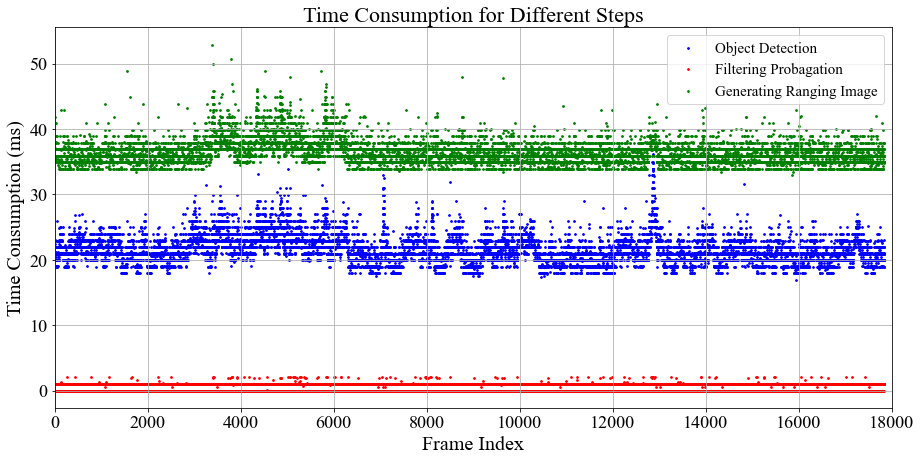

In [66]:
plt.figure(figsize=(15,7))
plt.grid()
plt.scatter(np.arange(len(t_db)),t_db, c = 'b',  label = 'Object Detection', s = 3)
plt.scatter(np.arange(len(t_bf)),t_bf, c = 'r',  label = 'Filtering Probagation', s = 3)
plt.scatter(np.arange(len(t_rimg)),t_rimg, c = 'g',  label = 'Generating Ranging Image', s = 3)
plt.legend(fontsize = 15, loc = 'upper right')
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.xlim(0,18000)
plt.xlabel('Frame Index',fontsize = 20)
plt.ylabel('Time Consumption (ms)',fontsize = 20)
plt.title('Time Consumption for Different Steps', fontsize = 22)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\TimeConsumptionSteps.tif',dpi = 300)
plt.show()

In [65]:
360 * 10 * 32/576000

0.2

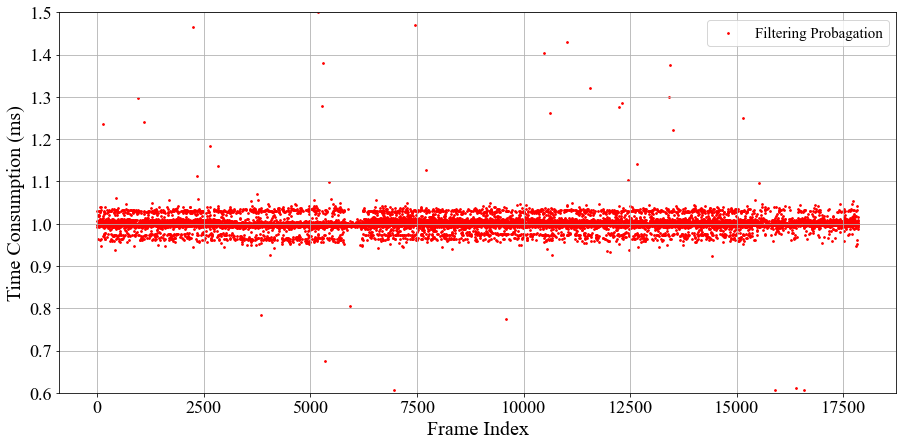

In [71]:
plt.figure(figsize=(15,7))
plt.grid()
# plt.scatter(np.arange(len(t_db)),t_db, c = 'b',  label = 'Object Detection', s = 3)
plt.scatter(np.arange(len(t_bf)),t_bf, c = 'r',  label = 'Filtering Probagation', s = 3)
# plt.scatter(np.arange(len(t_rimg)),t_rimg, c = 'g',  label = 'Generating Ranging Image', s = 3)
plt.legend(fontsize = 15, loc = 'upper right')
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylim(0.6,1.5)
plt.xlabel('Frame Index',fontsize = 20)
plt.ylabel('Time Consumption (ms)',fontsize = 20)
# plt.title('Time Consumption for Different Steps', fontsize = 22)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\TimeConsumptionProb.tif',dpi = 300)
plt.show()

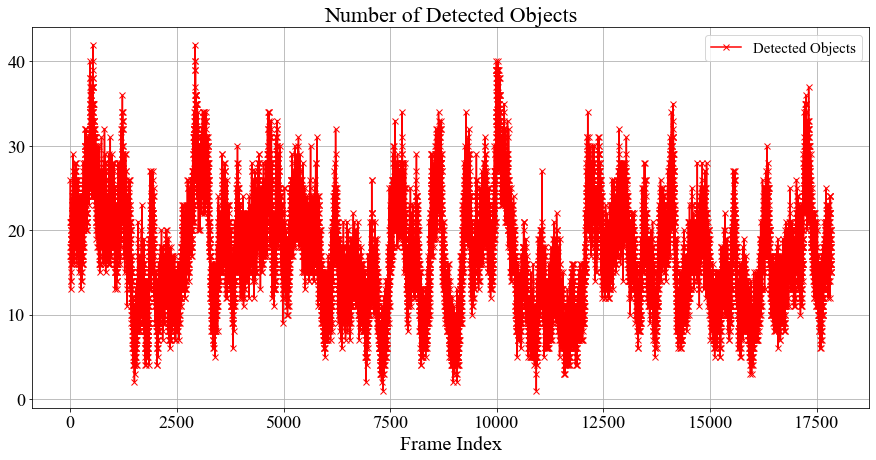

In [18]:
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(num, c = 'r', marker = 'x', label = 'Detected Objects')

plt.legend(fontsize = 15, loc = 'upper right')
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
# plt.ylim(0,0.15)
plt.xlabel('Frame Index',fontsize = 20)
# plt.ylabel('Range of $t_s$ ',fontsize = 20)
plt.title('Number of Detected Objects', fontsize = 22)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\roNBTU_ts_weekend_zoomin.tif',dpi = 300)
plt.show()

In [23]:
np.argmax(num)

535

In [36]:
db = Raster_DBSCAN(window_size=[9,23],eps = 1.8,min_samples = 5,Td_map_szie = [32,1800])
Td_map = aggregated_map[450]
Foreground_map = ~(np.abs(Td_map - thred_map) <= 0.9).any(axis = 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
pcd = get_pcd_colored(Td_map,Labeling_map)
draw(pcd,height=1000,width=1000)# Labeling_map = self.db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)

WebVisualizer(window_uid='window_18')

In [38]:
42/(15*60)

0.04666666666666667

In [30]:
db = Raster_DBSCAN(window_size=[9,23],eps = 1.8,min_samples = 5,Td_map_szie = [32,1800])
Td_map = aggregated_map[534]
Foreground_map = ~(np.abs(Td_map - thred_map) <= 0.9).any(axis = 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
pcd = get_pcd_colored(Td_map,Labeling_map)
draw(pcd,height=1000,width=1000)# Labeling_map = self.db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)

WebVisualizer(window_uid='window_12')

In [ ]:
pcd = get_pcd_colored(Td_map,Labeling_map)
draw(pcd,height=1000,width=1000)# Labeling_map = self.db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)